# template notebook to be expanded
 * add description here
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# create plots of the data
show_data = False

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
for dataname in datafiles:

    if 'seaflow' in dataname:
        # Extract SeaFlow cell counts
        seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
        seaflow_counts = seaflow.values[:, 2:].T.astype(int)

        # Redefine parameters to match 32-size class count data. We only keep PAR from the 25-size class data.
        data_gridded[dataname]['m'] = seaflow_counts.shape[0]
        data_gridded[dataname]['size_bounds'] = seaflow.columns[2:].values.astype(float) # extract size classes from dataframe
        data_gridded[dataname]['v_min'] = data_gridded[dataname]['size_bounds'][0] # note these seem to be on a different scale
        data_gridded[dataname]['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded[dataname]['size_bounds'][1]/data_gridded[dataname]['size_bounds'][0])))
        data_gridded[dataname]['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
        data_gridded[dataname]['counts'] = seaflow_counts
        data_gridded[dataname]['obs_time'] = np.empty(shape=seaflow_counts.shape[1])

        # Extract time stamps for each observation from SeaFlow data
        ii = 0
        for timestamp in np.asarray(seaflow['time'], dtype=str):
            datetime = dateutil.parser.isoparse(timestamp)
            if ii == 0:
                initial = datetime
            data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
            ii += 1

    elif 'zinser' in dataname:

        # Extract Zinser cell counts
        zinser = pd.read_csv('data/Zinser_Figure2A.csv')
        #zinser_counts = zinser.values[:,1].astype(int) # cells A column
        #zinser_counts = zinser.values[:,2].astype(int) # cells B column
        zinser_counts = np.mean(zinser.values, axis=1).astype(int) # mean of both columns
        
        # Add counts to Zinser data
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['w_obs'] * zinser_counts).astype(int)
        data_gridded[dataname]['obs_time'] = data_gridded[dataname]['time']

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3
        sharex = np.array_equal(data_gridded[dataname]['time'], data_gridded[dataname]['obs_time'])

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=sharex, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['counts'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
                
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    # load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    
    # switch on or off data fitting
    data[dataname]['prior_only'] = 0
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

In [4]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs_count'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [21]:
import pystan
import re

desc_model = {
    #'m1':'m1',
    #'m2':'m2',
    #'m3':'m3',
    #'m4':'m4',
    'm5':'m5',
    'm6':'m6',
    'm7':'m7',
    'm8':'m8',
    'm9':'m9',
    'm10':'m10',
    #'m11':'m5-m6 hybrid',
    #'m12':'m5-m7 hybrid',
    #'m13':'m5-m8 hybrid',
    #'m14':'m5-m9 hybrid',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c56',
    'm12':'c57',
    'm13':'c58',
    'm14':'c59',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
    'c56':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c57':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
    'c58':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c59':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6 NOW.


m5: unchanged code, not recompiling
m6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m7 NOW.


m7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m8 NOW.


m8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m9 NOW.


m9: compiling
m10: unchanged code, not recompiling


In [23]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

refit_all = False
try_again = False

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    continue
        else:
            mcmcs[model] = {}
        for itry in range(3):
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(model,itry+1,rhat_max))
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


m5 (m5)
Inference for Stan model: m5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.16    0.23   7.94  21.71  28.44  33.09  38.77  52.63   1233    1.0
gamma_max           1.47  1.1e-3   0.06   1.37   1.43   1.47   1.51   1.61   3258    1.0
rho_max           7.1e-4  9.9e-6 7.2e-4 1.5e-5 2.0e-4 4.9e-4 9.6e-4 2.7e-3   5305    1.0
E_star            183.16    3.05 147.59  41.88   82.1  125.8 240.28 579.86   2335    1.0
sigma             917.38    0.64  44.88  829.5 886.58 916.51 947.35 1006.7   4930    1.0
divrate             0.72  3.8e-4   0.02   0.67    0.7   0.72   0.74   0.76   3971    1.0
delta[1]          3.3e-4  4.6e-6 3.4e-4 8.5e-6 9.8e-5 2.3e-4 4.5e-4 1.3e-3   5481    1.0
delta[2]            0.27  4.2e-4   0.03   0.22   0.26   0.27   0.29   0.33   3875    1.0
delta[3]            1.05  1.0e-3   0.07   0

m10 (m10)
Inference for Stan model: m10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           8.65    0.02   0.99   7.07   7.95   8.52   9.21  10.87   2493    1.0
delta_lightthresh  13.36    0.17   7.09   0.76   8.24  13.46  18.36  27.19   1784    1.0
delta_lightsigma     0.2  3.4e-4   0.02   0.16   0.19    0.2   0.21   0.24   3341    1.0
gamma_max           6.56    0.04   1.55   3.35   5.42   6.81   7.85   8.73   1487    1.0
rho_max             0.73  1.9e-3   0.08   0.57   0.67   0.73   0.78   0.89   1959    1.0
E_star            503.52    4.19 154.84 181.31 390.65 523.57 628.14 740.64   1363    1.0
sigma             293.79    0.27  17.06 261.37 282.17 293.34 304.76 328.93   3944    1.0
divrate             0.43  5.3e-4   0.03   0.37   0.41   0.43   0.45   0.48   2748    1.0
delta[1]            0.02  2.6e-4   0.02 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m6 (m6)
Inference for Stan model: m6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          53.73    0.19   8.28  39.12  47.56  53.26  59.75  70.05   1947    1.0
gamma_max           4.96  2.5e-3   0.19   4.46   4.88   5.02   5.11   5.16   6016    1.0
rho_max             2.36    0.02   1.53   0.06   0.98   2.29    3.7   5.01   7684    1.0
E_star            110.37    1.17  70.25  36.18  65.73  90.28 130.06 308.98   3634    1.0
sigma             1032.6    0.55  49.75 939.66 997.98 1031.2 1066.7 1132.7   8316    1.0
xi                  0.01  7.7e-6 5.6e-4   0.01   0.01   0.01   0.01   0.01   5293    1.0
xir                 0.14  1.0e-3   0.05   0.07   0.11   0.13   0.17   0.26   2519    1.0
divrate             0.77  3.2e-4   0.02   0.73   0.76   0.77   0.79   0.81   4782    1.0
delta[1]          2.9e-4  4.0e-6 3.0e-4 7.9

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m6 (m6)
Inference for Stan model: m6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           2.71  9.1e-3    0.4   2.01   2.44   2.68   2.95   3.57   1880    1.0
gamma_max           5.27  4.6e-3   0.19   4.94   5.14   5.26   5.38   5.71   1731    1.0
rho_max             2.08  1.9e-3   0.08   1.93   2.03   2.09   2.14   2.24   1745    1.0
E_star             79.53    0.28  11.35  59.84  72.05  78.64  85.84 105.74   1679    1.0
sigma             625.02    0.73  38.98 550.19 598.07 624.59 651.16 704.35   2863    1.0
xi                 -1.15  1.7e-3   0.08  -1.31  -1.21  -1.15   -1.1  -1.01   2134    1.0
xir                 0.49  1.7e-3   0.08   0.32   0.43   0.49   0.54   0.64   2390    1.0
divrate             0.33  4.5e-4   0.03   0.28   0.32   0.33   0.35   0.39   3512    1.0
delta[1]            0.02  3.9e-4   0.02 7.9

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m7 (m7)
Inference for Stan model: m7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          53.49    0.19   8.22   38.2  47.38  53.19  59.31  69.77   1922    1.0
gamma_max           4.95  2.5e-3    0.2   4.44   4.87   5.02    5.1   5.16   6307    1.0
rho_max             2.35    0.02   1.52   0.06    1.0   2.24   3.63   5.03   7777    1.0
E_star            112.48    1.19  74.07  35.16  65.15   90.6 131.91 325.14   3858    1.0
sigma             1033.6     0.6  50.21 934.65 999.68 1033.1 1067.1 1132.8   7109    1.0
xi                  0.01  8.2e-6 5.8e-4   0.01   0.01   0.01   0.01   0.01   4982    1.0
xir                 0.14  9.4e-4   0.05   0.07   0.11   0.13   0.17   0.26   2802    1.0
divrate             0.77  3.1e-4   0.02   0.73   0.76   0.77   0.79   0.81   4829    1.0
delta[1]          2.9e-4  3.6e-6 2.9e-4 7.1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m7 (m7)
Inference for Stan model: m7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          37.02     0.1   5.76  26.88  33.03  36.59  40.53  49.71   3235    1.0
gamma_max           8.13  8.3e-3   0.52   6.93   7.82   8.24   8.55   8.79   3895    1.0
rho_max              1.5  1.4e-3   0.09   1.34   1.44    1.5   1.56   1.68   3897    1.0
E_star            192.21    0.39  24.55  138.2 176.77 195.87 210.24 230.91   4044    1.0
sigma             343.01    0.33  20.55 303.41  328.9 342.69 356.94 384.92   3798    1.0
xi                 -0.55  1.4e-3   0.11  -0.77  -0.62  -0.55  -0.48  -0.34   5821    1.0
xir                 0.27  1.5e-3    0.1   0.08    0.2   0.27   0.33   0.45   4462    1.0
divrate             0.73  7.7e-4   0.05   0.63   0.69   0.73   0.76   0.83   4379    1.0
delta[1]          7.1e-3  9.1e-5 6.7e-3 2.0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m8 (m8)
Inference for Stan model: m8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          13.01    0.21   4.75   7.62   9.93  11.85  14.65  25.05    525    1.0
gamma_max           1.87    0.02   0.48   1.24   1.57   1.78   2.04   3.18    882   1.01
rho_max             4.58    0.01   0.59   2.99   4.35   4.76    5.0   5.15   3037    1.0
E_star            426.12   18.77 528.17   8.35  97.94 237.02 511.16 2026.5    792   1.01
sigma             1142.9    0.92  56.07 1034.3 1105.1 1142.5 1180.1 1256.6   3692    1.0
xi                  0.01  3.8e-5 1.8e-3 6.7e-3 9.2e-3   0.01   0.01   0.01   2284    1.0
xir                 0.08  2.0e-4 9.7e-3   0.07   0.08   0.08   0.09   0.11   2327    1.0
delta_lightthresh   4.82     0.1   5.85    0.1   1.15   2.73   5.77  22.94   3766    1.0
delta_lightsigma    0.19  3.4e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m8 (m8)
Inference for Stan model: m8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           5.68    0.01   0.53   4.71   5.31   5.65   6.01   6.82   2299    1.0
gamma_max           3.83  2.4e-3   0.11   3.63   3.75   3.82    3.9   4.08   2227    1.0
rho_max             1.47  2.6e-3    0.1   1.26   1.39   1.47   1.54   1.67   1648    1.0
E_star             49.03    0.23  10.72  30.61  42.45  47.67  54.07  75.75   2100    1.0
sigma             771.27     1.0  50.67 676.14 736.23 769.47 803.94 875.95   2559    1.0
xi                 -1.32  1.6e-3   0.08  -1.47  -1.37  -1.32  -1.27  -1.17   2145    1.0
xir                 0.55  1.5e-3   0.08   0.39   0.49   0.55   0.61   0.71   2969    1.0
delta_lightthresh  49.94    0.15   6.98  37.71  44.85  49.41  54.66  64.46   2199    1.0
delta_lightsigma    0.21  3.2e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m9 (m9)
Inference for Stan model: m9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          14.68     0.2   5.29   8.09  10.87  13.53   17.1  28.64    682    1.0
gamma_max           1.96    0.01   0.46   1.33   1.67   1.88   2.13   3.14   1087    1.0
rho_max             4.56  9.0e-3   0.58   3.01   4.32   4.73   4.98   5.15   4141    1.0
E_star            386.05   16.68  494.6    7.9  94.21 216.76 448.08 1923.1    880    1.0
sigma             1140.6    0.84  57.75 1031.5 1100.9 1140.0 1179.7 1254.7   4675    1.0
xi                  0.01  3.4e-5 1.8e-3 7.3e-3 9.8e-3   0.01   0.01   0.01   2845    1.0
xir                 0.09  2.6e-4   0.01   0.07   0.08   0.09   0.09   0.12   1874    1.0
delta_lightthresh   5.16    0.09   5.98    0.1    1.3   3.05   6.34  22.91   4123    1.0
delta_lightsigma    0.19  3.0e-4   0.02   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m9 (m9)
Inference for Stan model: m9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.14    0.02   0.92   8.64   9.49  10.04   10.7  12.18   1916    1.0
gamma_max           7.69    0.02   0.89   5.55   7.13    7.9   8.41   8.78   1505    1.0
rho_max             0.01  1.8e-4   0.01 3.8e-4 4.0e-3 9.3e-3   0.02   0.05   4787    1.0
E_star            701.75    2.45  98.54 470.58  641.8 718.26 775.53 848.24   1619    1.0
sigma             429.38    0.67  33.35 366.88  406.2 428.27  451.1 495.54   2444    1.0
xi                  -1.4  2.3e-3   0.12  -1.63  -1.48  -1.41  -1.33  -1.17   2697    1.0
xir                 0.02  1.7e-3   0.11  -0.19  -0.06   0.02   0.09   0.23   3945    1.0
delta_lightthresh  11.43    0.12   4.72   1.08   8.51  11.76  14.64  19.95   1665    1.0
delta_lightsigma     0.2  2.9e-4   0.02   0

## plot the results

In [24]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [25]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

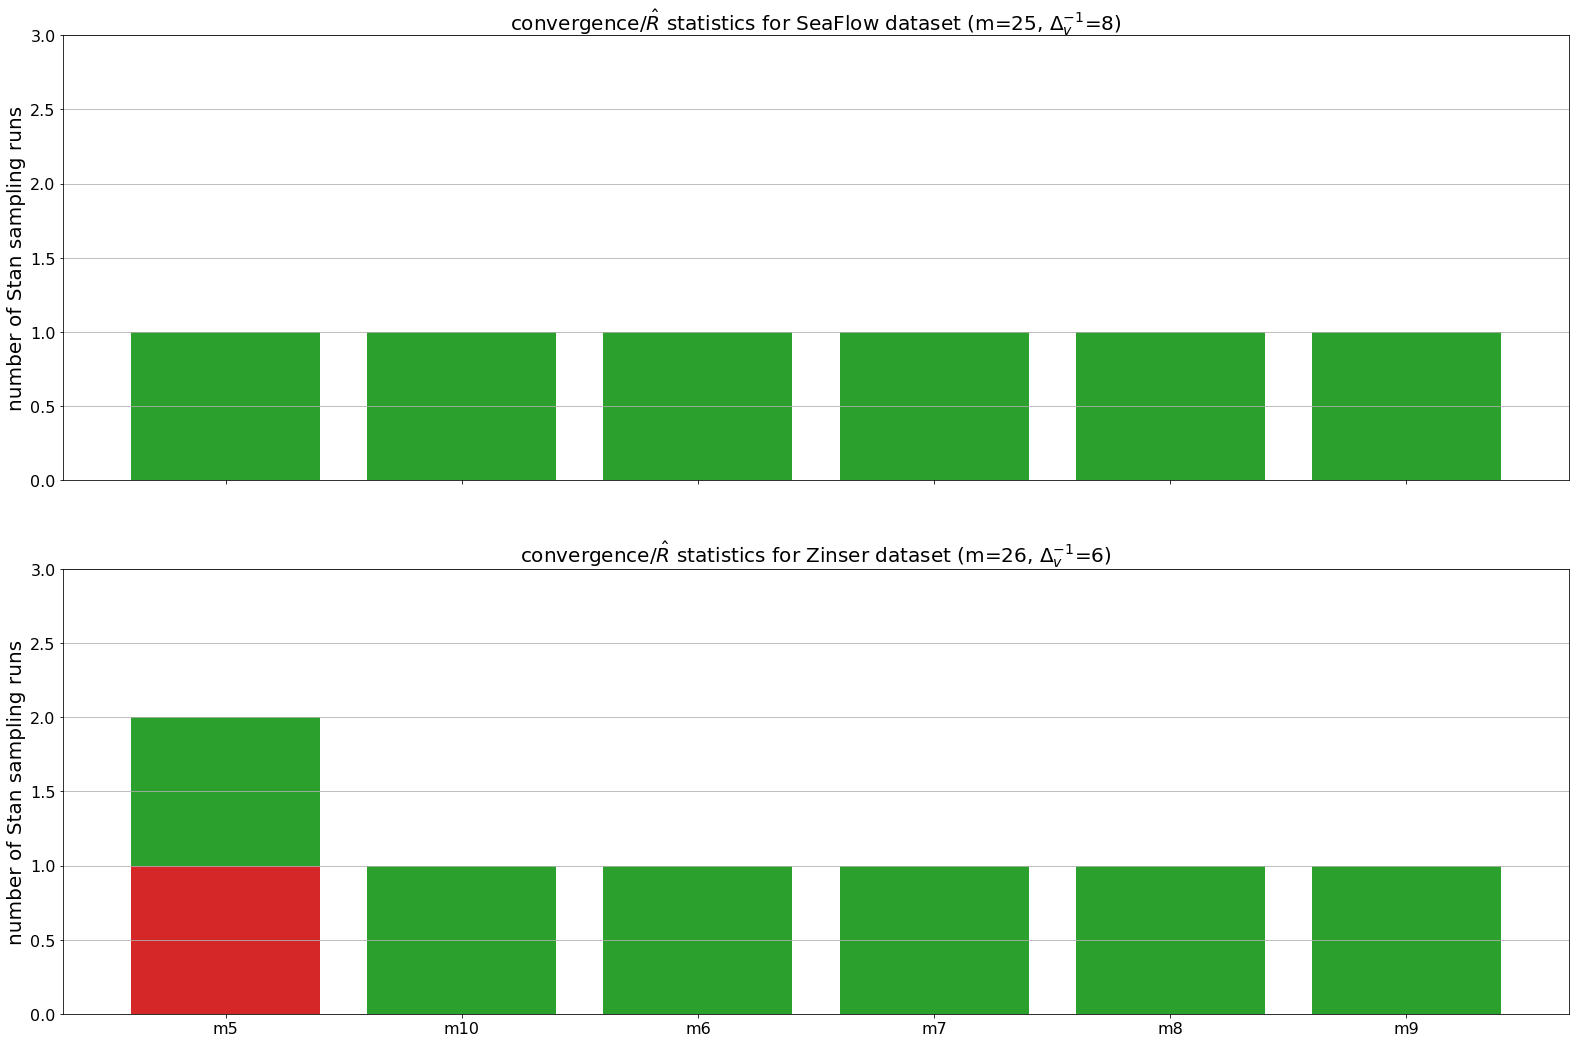

In [26]:
ylim_top = 0
for dataname in data:
    for model in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[model][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[model][dataname])
        height_good = len(maxrhats[model][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[model].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

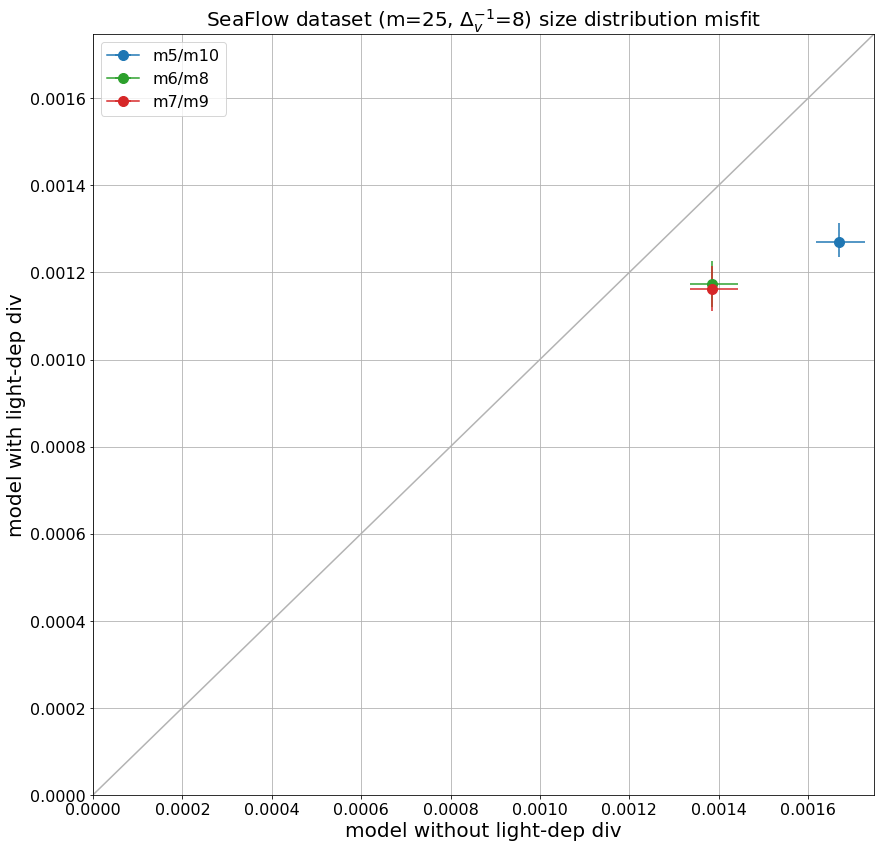

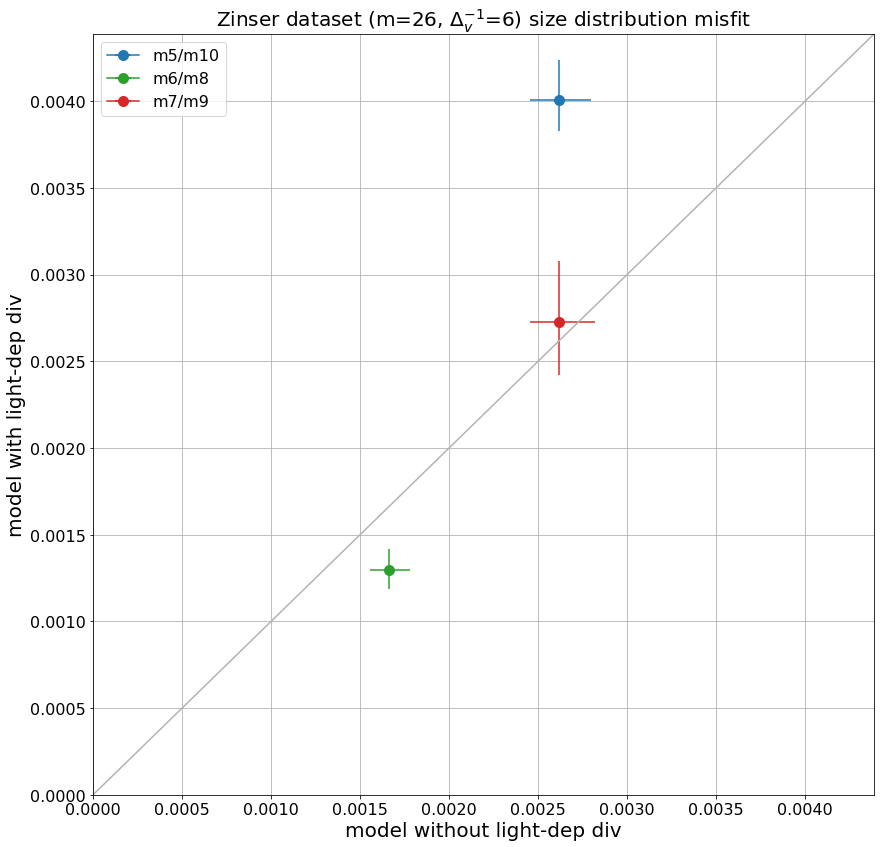

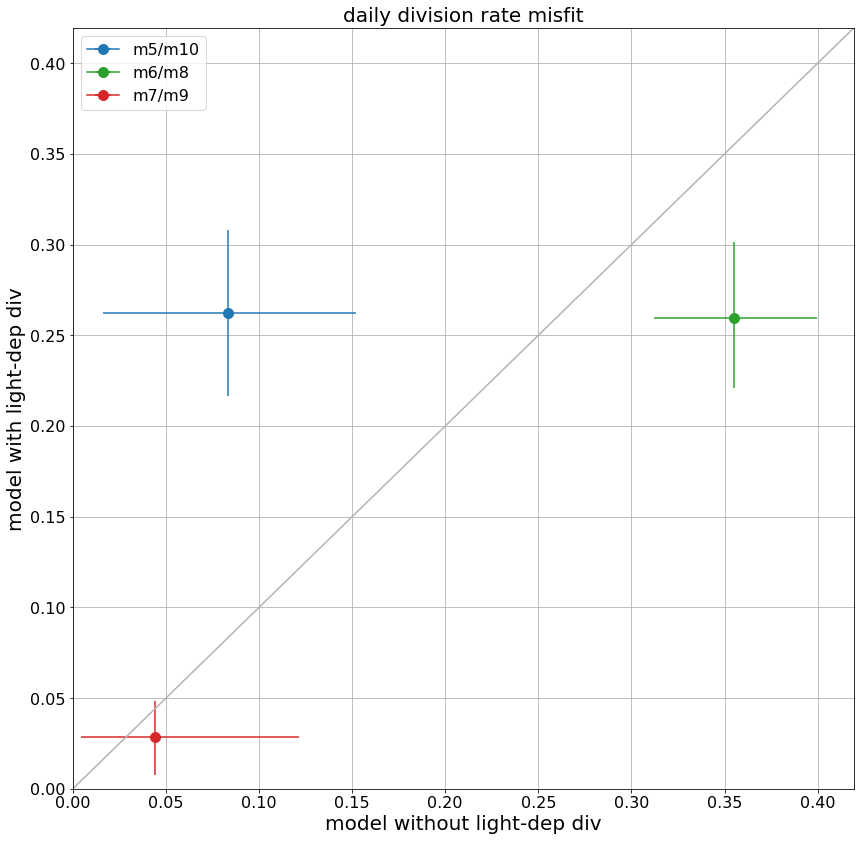

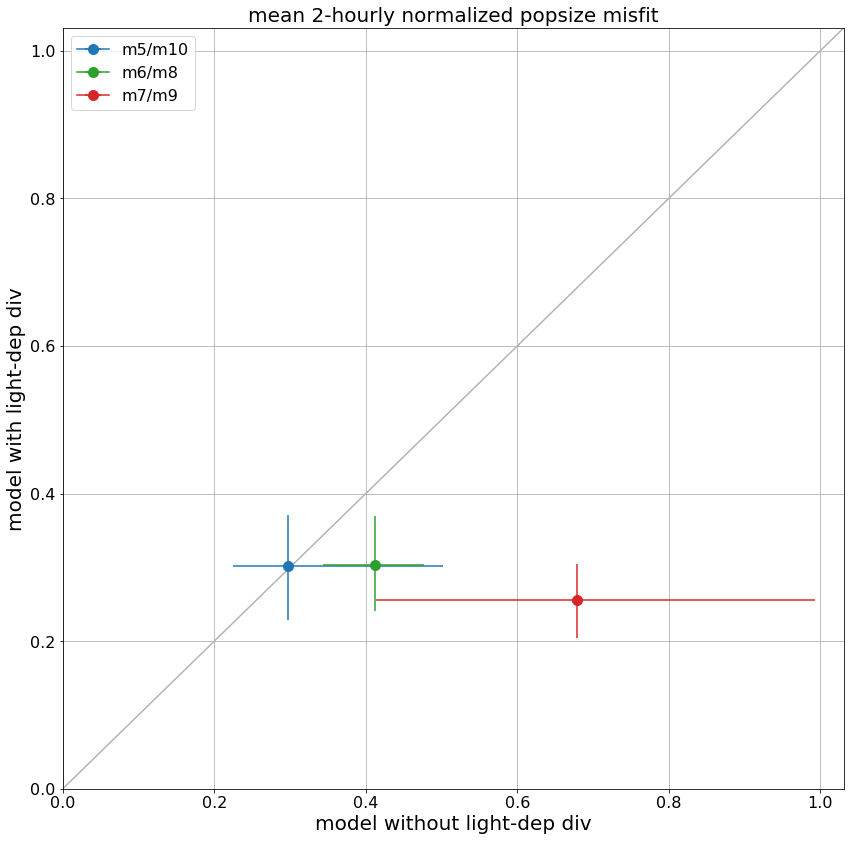

In [27]:
model_equivalents = {
    'm5':'m10',
    'm6':'m8',
    'm7':'m9',
    'm11':'m13',
    'm12':'m14',
}

data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')
t_zinser = data_fig2a['exper time'] * 60
ab_mean_norm = 0.5*(data_fig2a['cells A'].values/data_fig2a['cells A'].values[0] + 
                    data_fig2a['cells B'].values/data_fig2a['cells B'].values[0])

qq = {}

datanames = tuple(data.keys())
for model in mcmcs:
    for dataname in datanames:
        #
        # misfit to size data
        #
        obs = data[dataname]['obs']

        tmp = mcmcs[model][dataname]['mod_obspos']
        tmp/= np.sum(tmp, axis=1)[:,None,:]
        tmp -= obs[None,:,:]
        tmp **= 2

        if np.all(data[dataname]['i_test'] == 0):
            e0 = np.mean(np.sum(tmp, axis=1), axis=1)
            propname = dataname + ';' + desc[dataname] + ' size distribution misfit'
        else:
            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            propname = dataname + ';' + desc[dataname] + 'size distribution misfit (test data)'
        
        if propname not in qq:
            qq[propname] = {}
        qq[propname][model] = np.percentile(e0, q=(5,25,50,75,95))

        if 'zinser' in dataname:
            #
            # misfit to daily division rate
            #
            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
            
            propname = dataname + ';' + 'daily division rate misfit'
            if propname not in qq:
                qq[propname] = {}
            qq[propname][model] = np.percentile(e1, q=(5,25,50,75,95))
            
            #
            # misfit to 2-hourly pop size
            #
            e2 = np.mean(np.abs(np.sum(mcmcs[model][dataname]['mod_obspos'], axis=1)[:,1:]-ab_mean_norm[1:-1]), axis=1)
            propname = dataname + ';' + 'mean 2-hourly normalized popsize misfit'
            if propname not in qq:
                qq[propname] = {}
            qq[propname][model] = np.percentile(e2, q=(5,25,50,75,95))
            

for propname in qq:
    dataname, proplabel = propname.split(';')
    
    fig, ax = plt.subplots(figsize=(14,14))
    ax.set_title(proplabel, size=20)
    for model0,model1 in model_equivalents.items():
        if model0 not in mcmcs:
            continue
        
        q0 = qq[propname][model0]
        q1 = qq[propname][model1]

        eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label='{}/{}'.format(desc_model[model0], desc_model[model1]), color=colors_model[model0])
        ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
        if maxrhats_final[model0][dataname] > 1.1 or maxrhats_final[model1][dataname] > 1.1:
            ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)

    
    ax.grid(True)
    ax.legend()
    ax.set(xlabel='model without light-dep div', 
           ylabel='model with light-dep div')
    lim = (0,max(ax.get_xlim()[1], ax.get_ylim()[1]))
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim, lim, color='0.7')
    None

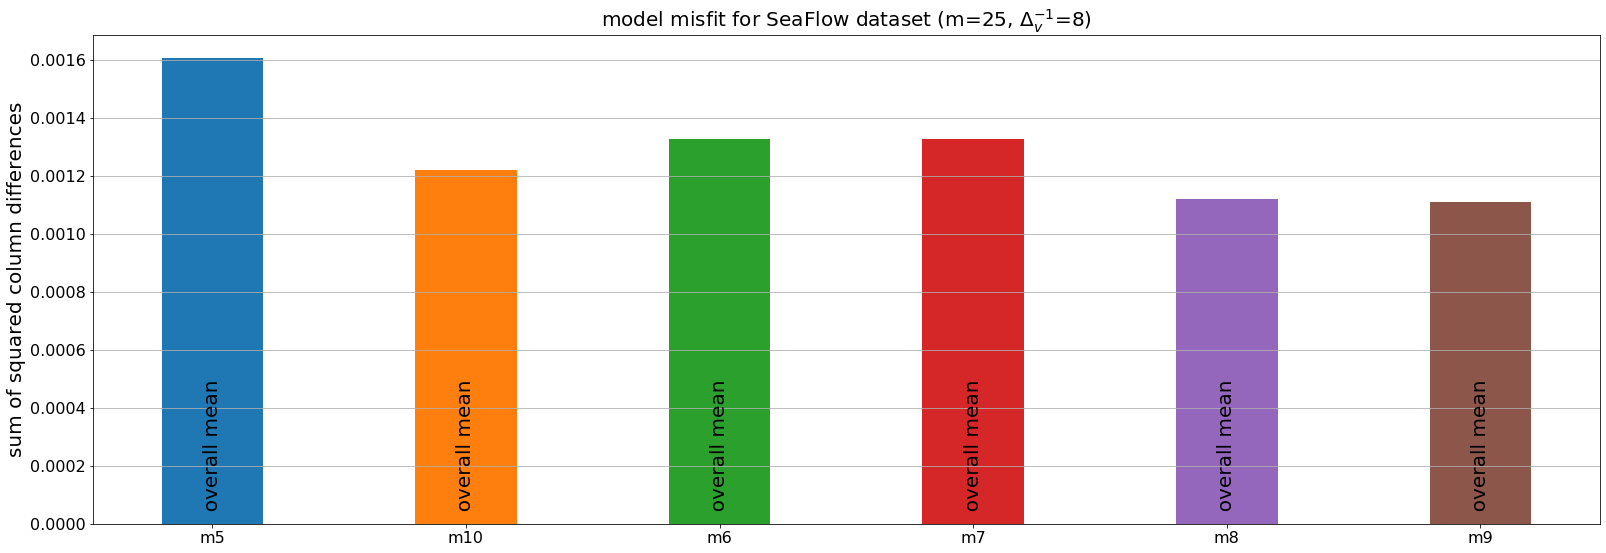

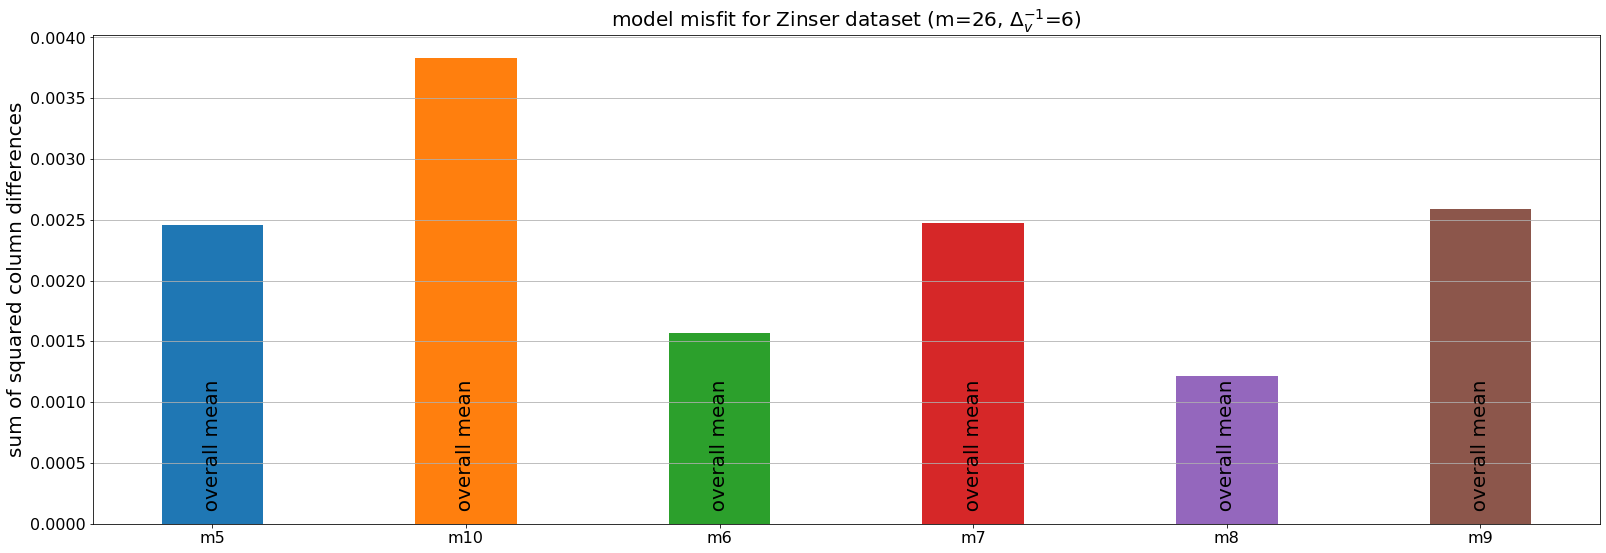

In [28]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,model in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[model],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[model])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[model].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

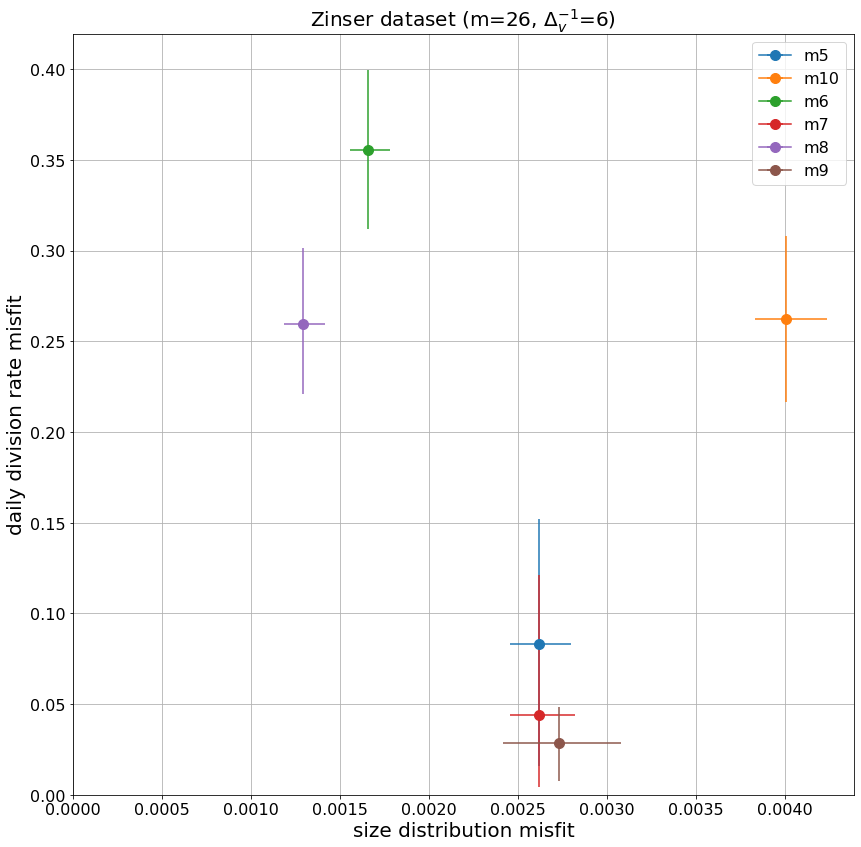

In [29]:
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))
        ax.set_title(desc[dataname], size=20)
        
        for model in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.abs(mcmcs[model][dataname]['divrate'] - reference_values[dataname]['divrate'])
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))
            
            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
            if maxrhats_final[model][dataname] > 1.1:
                ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

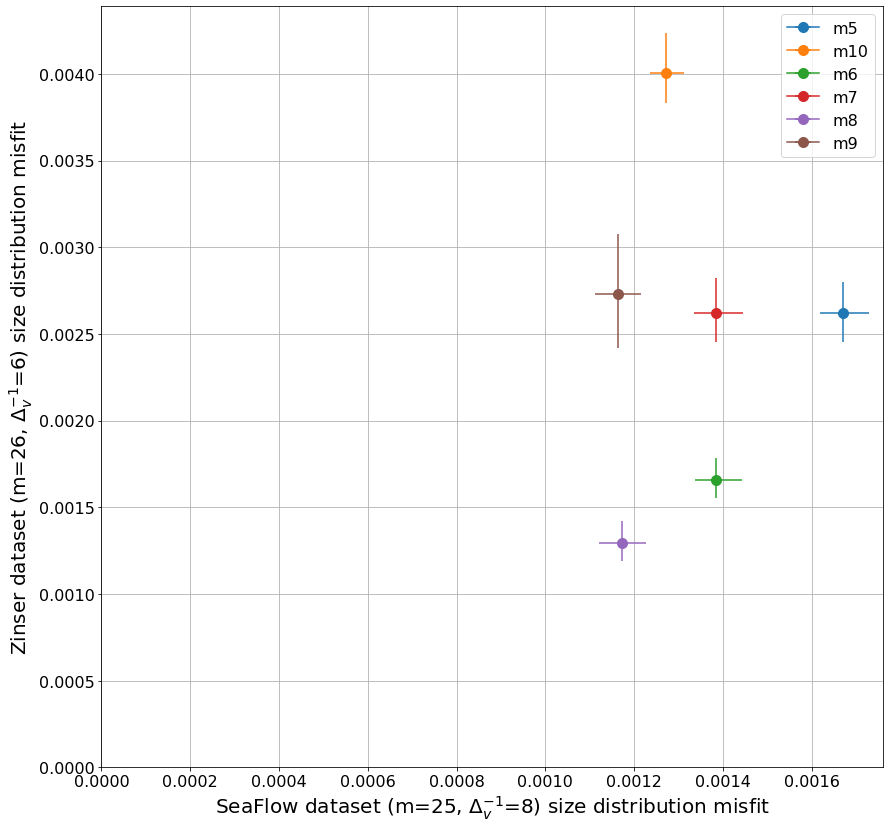

In [30]:
fig, ax = plt.subplots(figsize=(14,14))

datanames = tuple(data.keys())
for model in mcmcs:
    qq = {}
    # misfit to data
    for dataname in datanames:
        obs = data[dataname]['obs']

        tmp = mcmcs[model][dataname]['mod_obspos']
        tmp/= np.sum(tmp, axis=1)[:,None,:]
        tmp -= obs[None,:,:]
        tmp **= 2

        if np.all(data[dataname]['i_test'] == 0):
            e0 = np.mean(np.sum(tmp, axis=1), axis=1)
        else:
            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

        qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))
    
    q0 = qq[datanames[0]]
    q1 = qq[datanames[1]]
    
    eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=desc_model[model], color=colors_model[model])
    ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())
    if maxrhats_final[model][dataname] > 1.1:
        ax.plot(q0[2], q1[2], marker='x', color='darkred', zorder=10, markersize=30, markeredgewidth=3)
    
ax.grid(True)
ax.legend()
ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
       ylabel='{} size distribution misfit'.format(desc[datanames[1]]))
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)
None

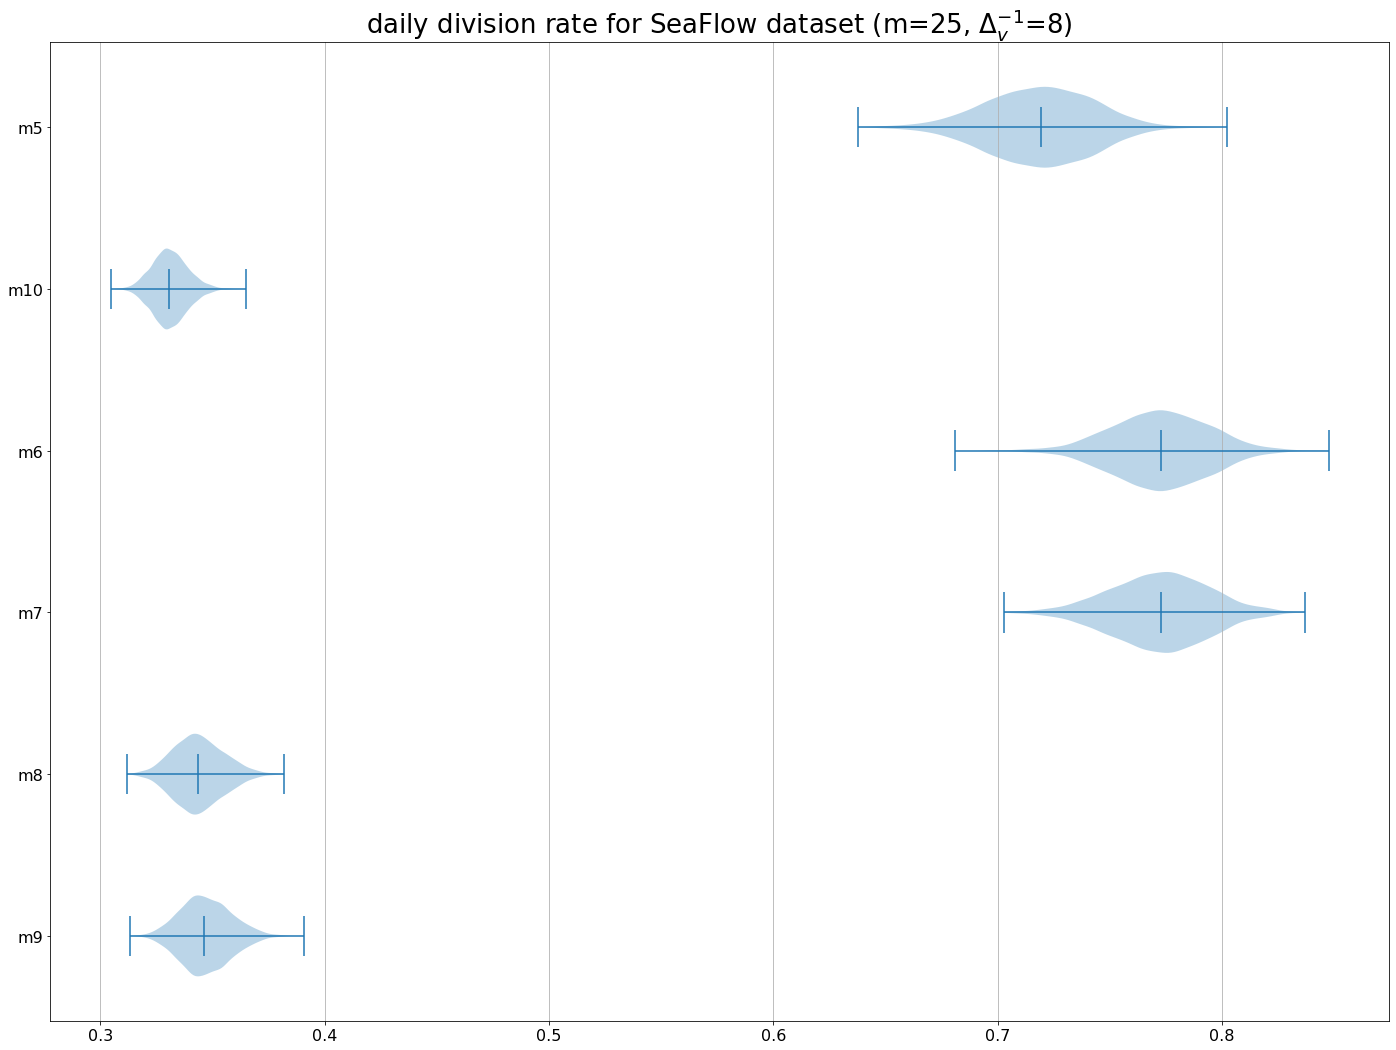

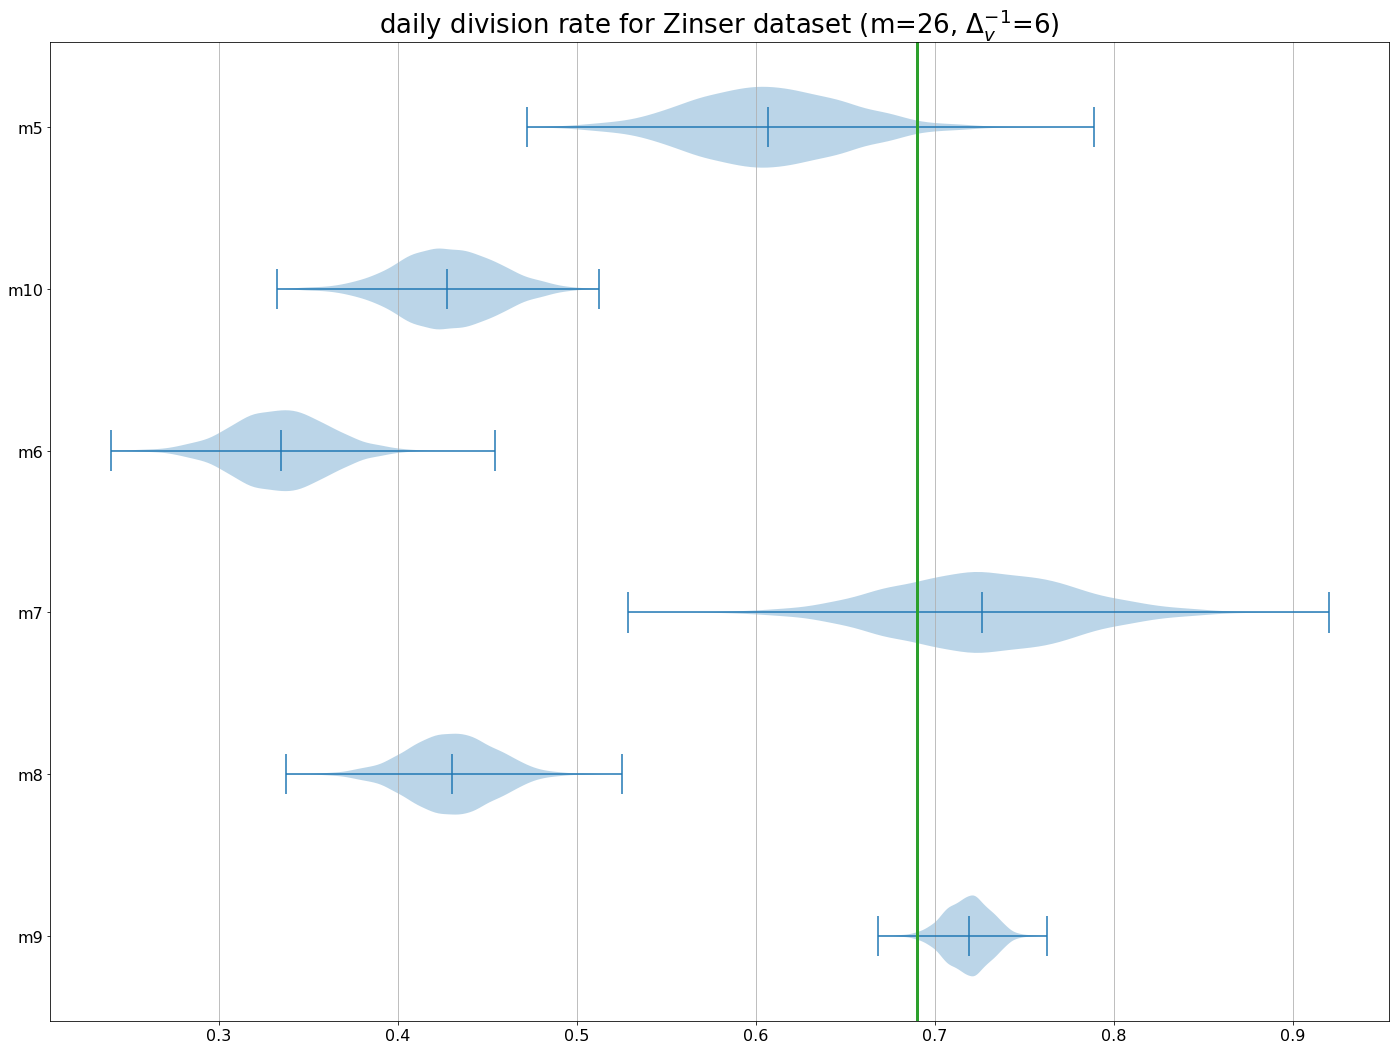

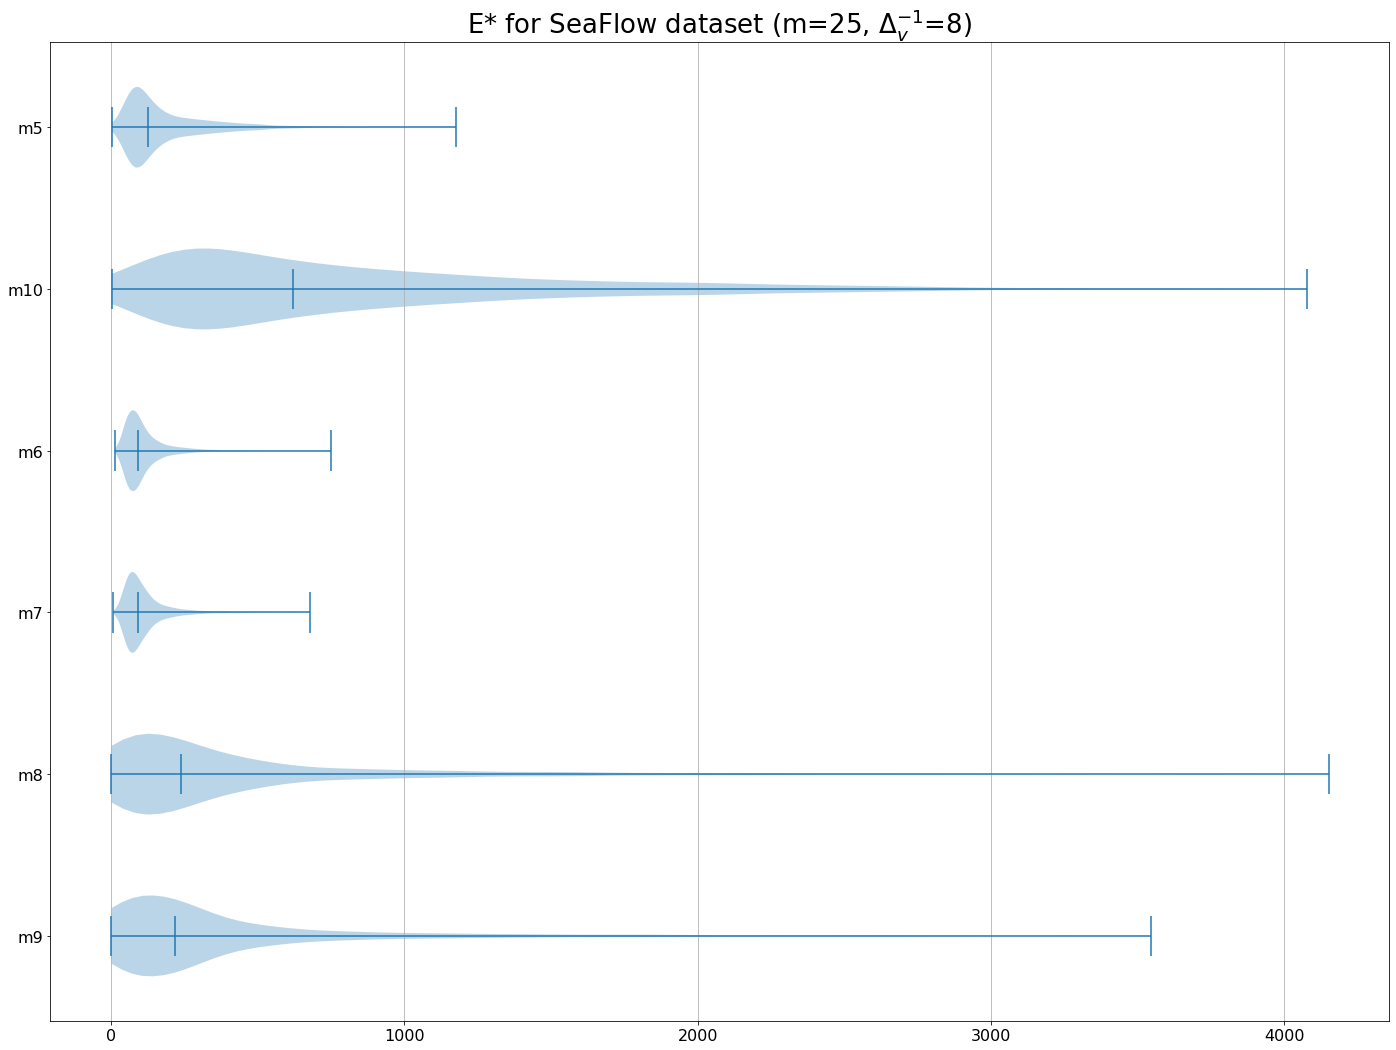

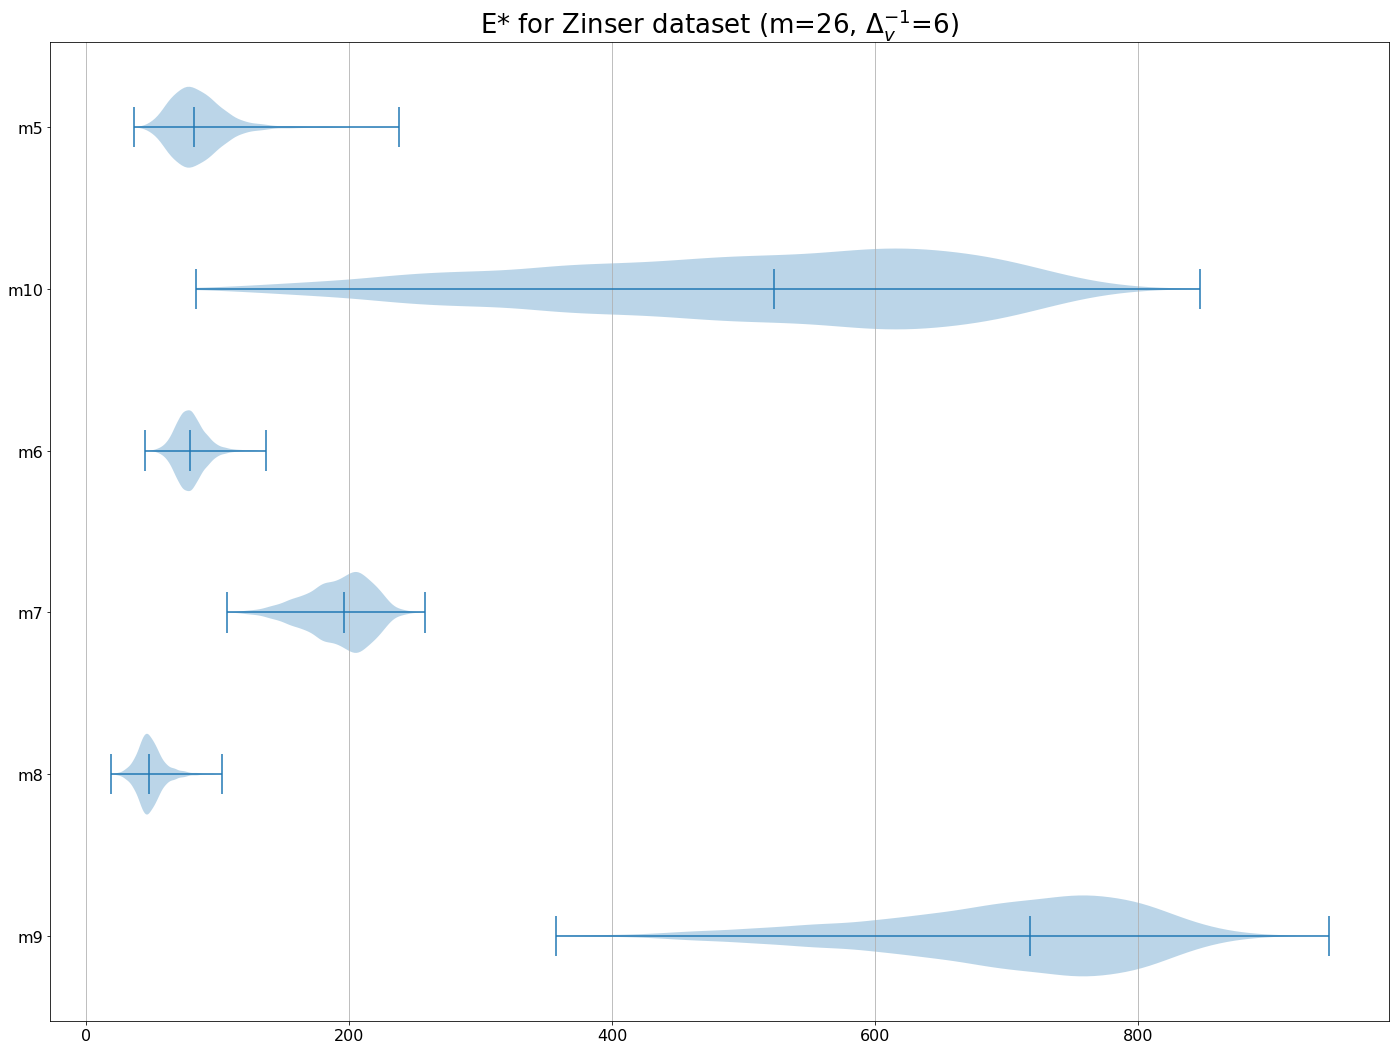

In [31]:
for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[model][dataname][param] for model in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[model].replace(',',',\n') for model in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,model in enumerate(mcmcs):
            if maxrhats_final[model][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

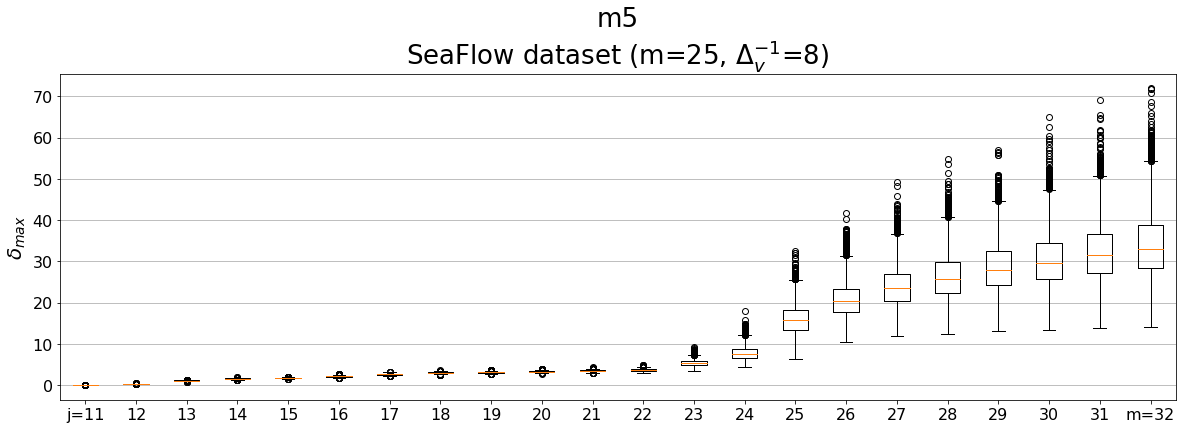

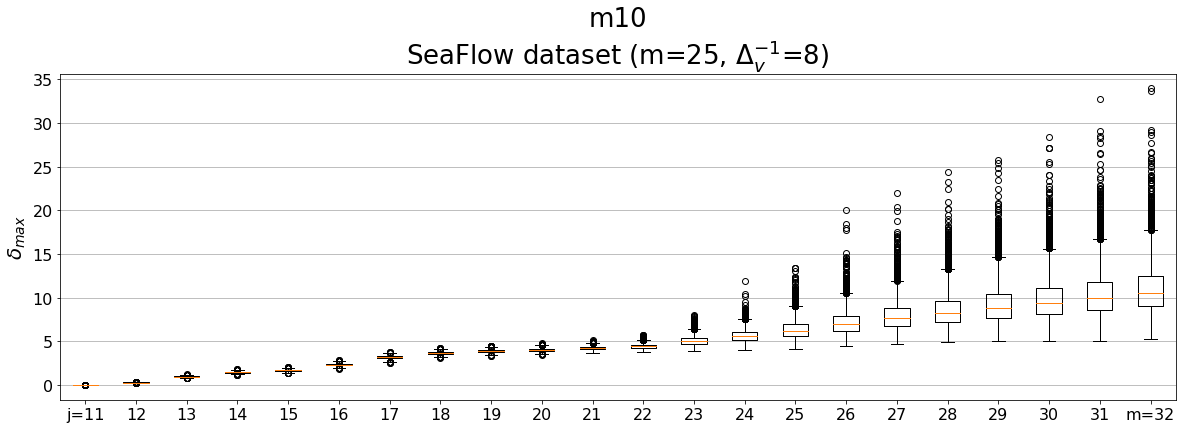

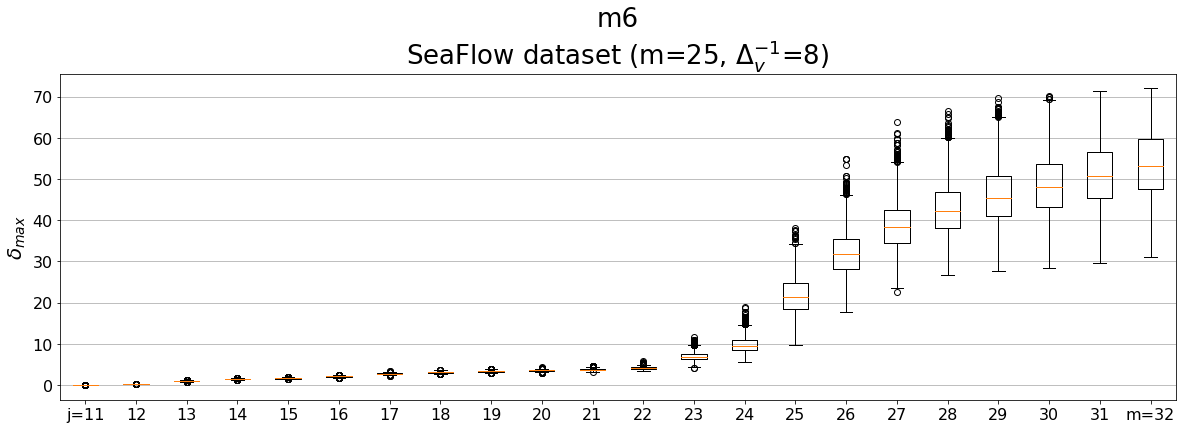

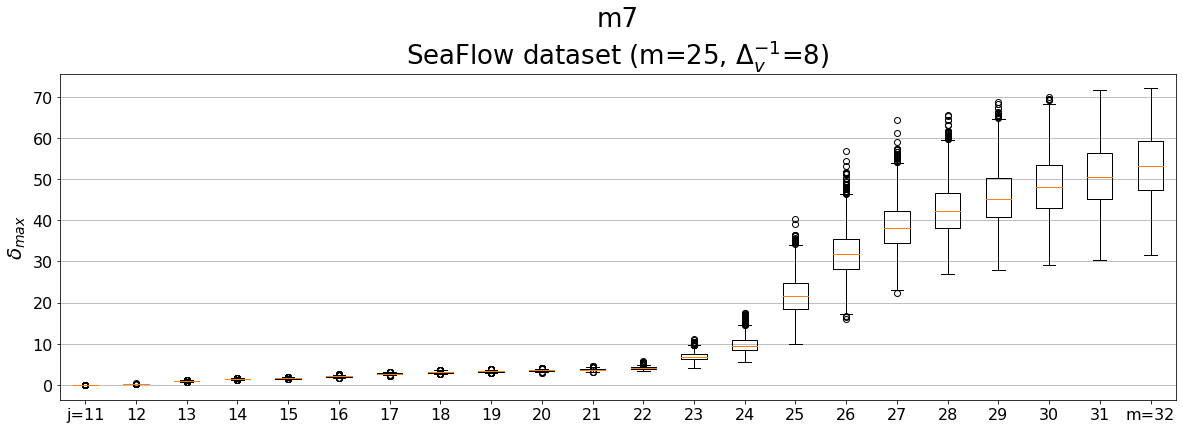

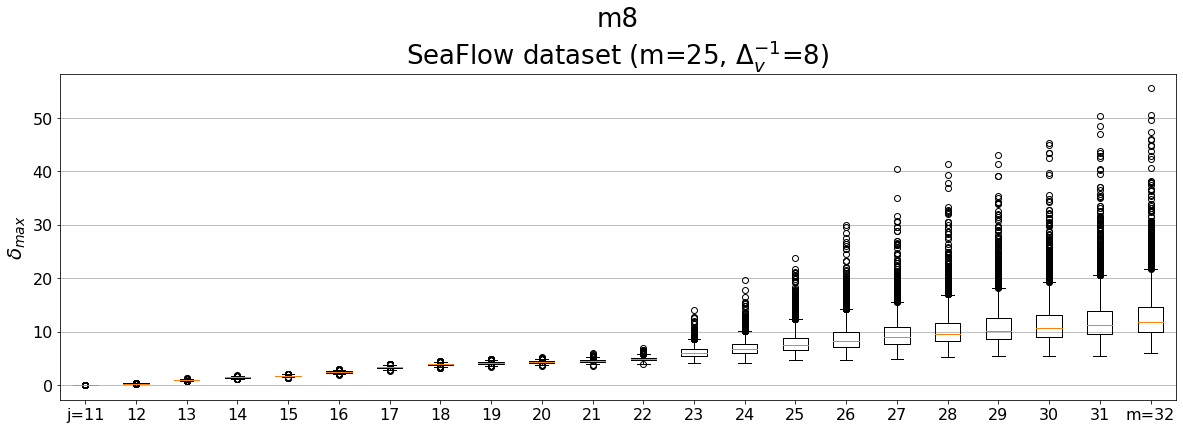

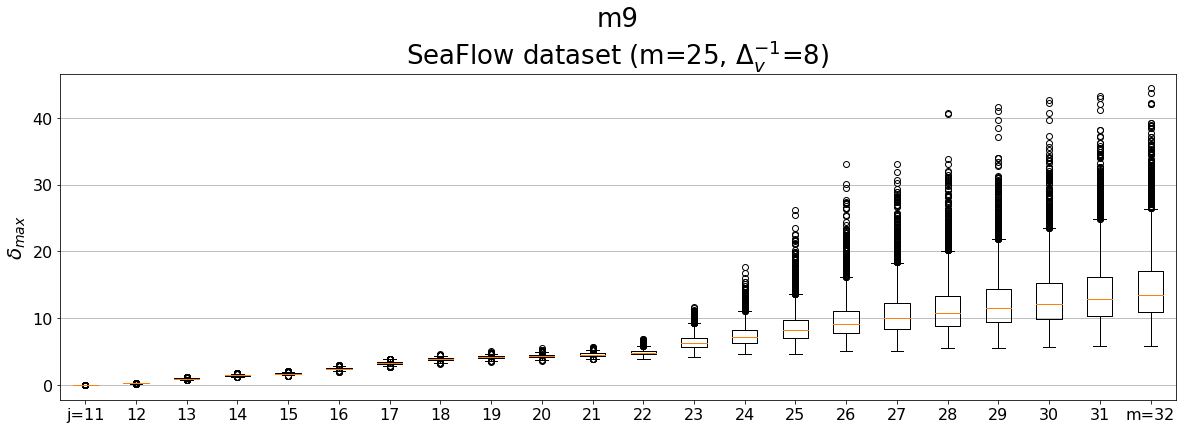

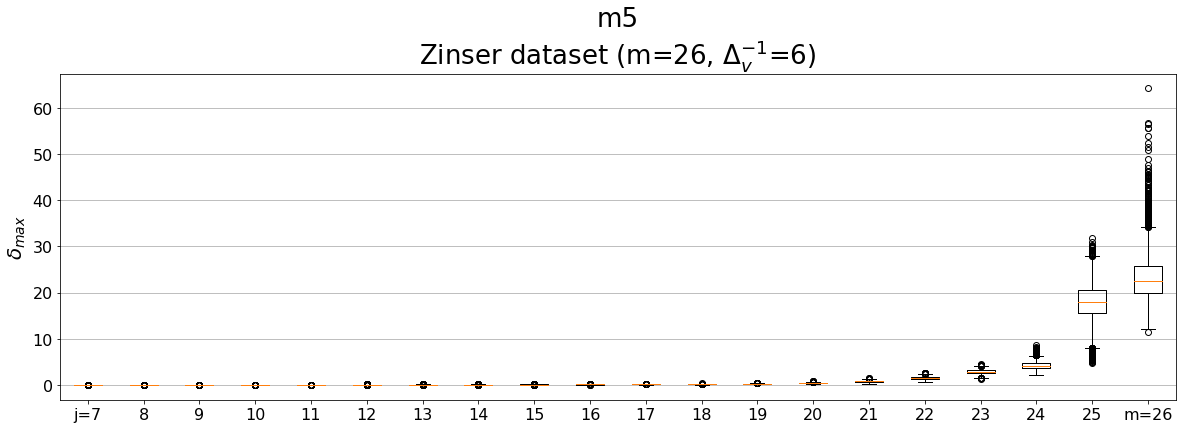

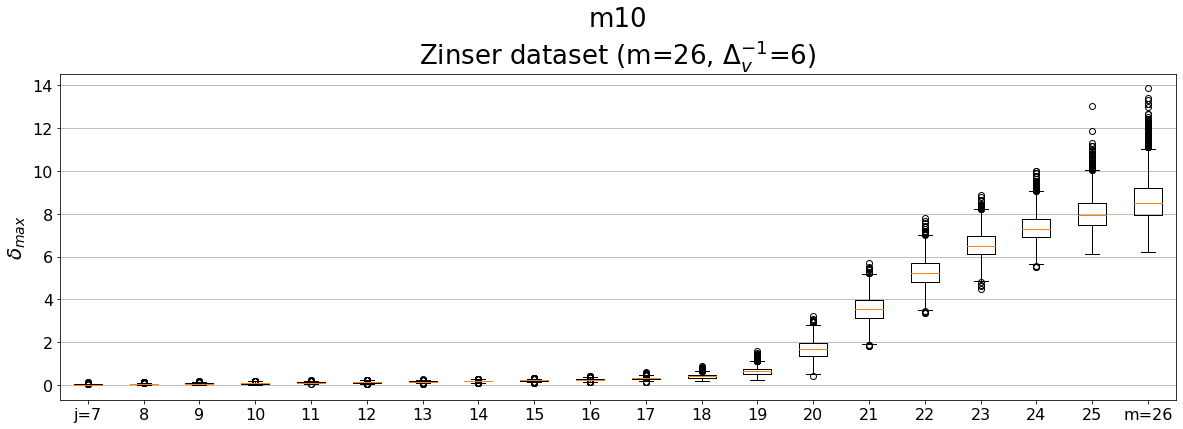

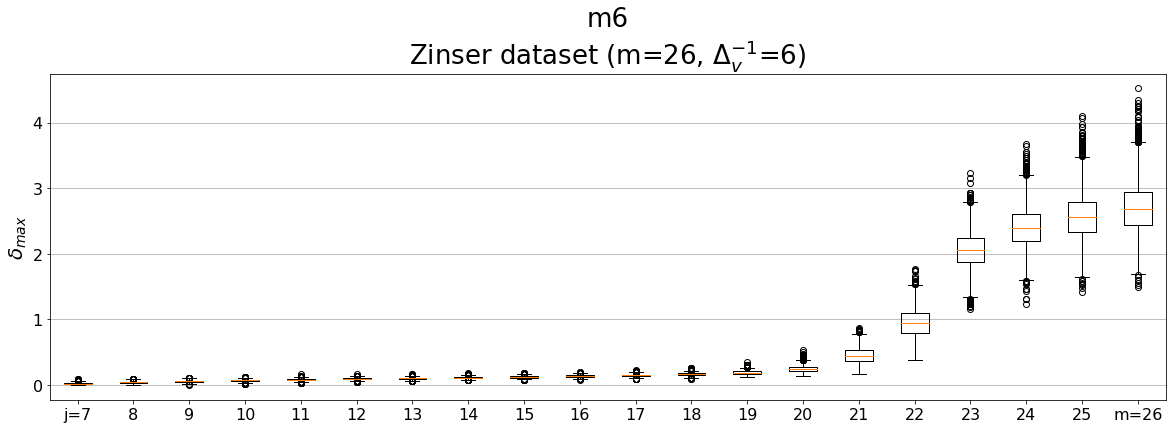

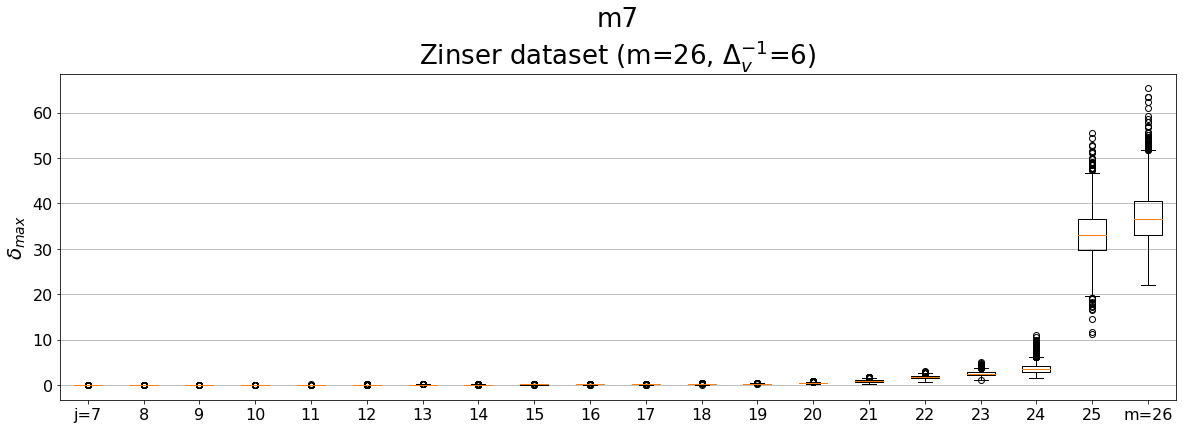

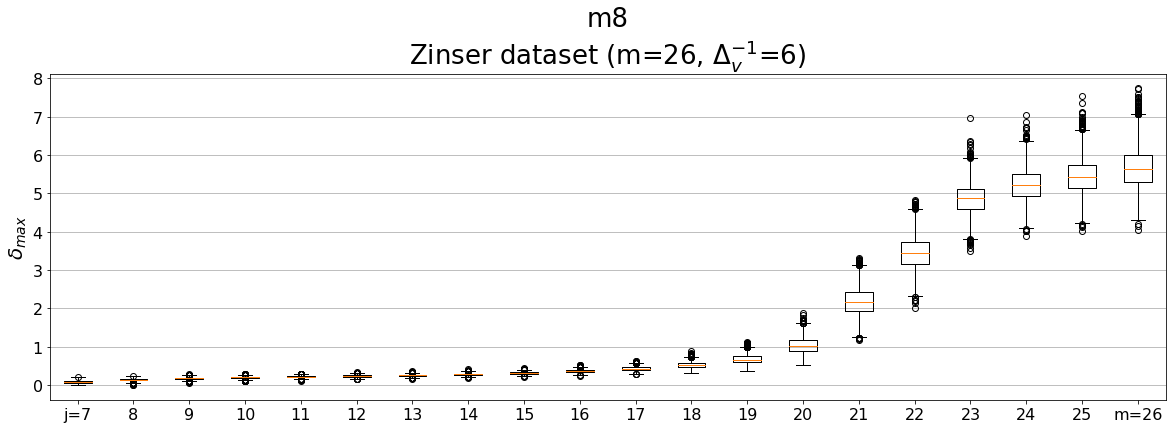

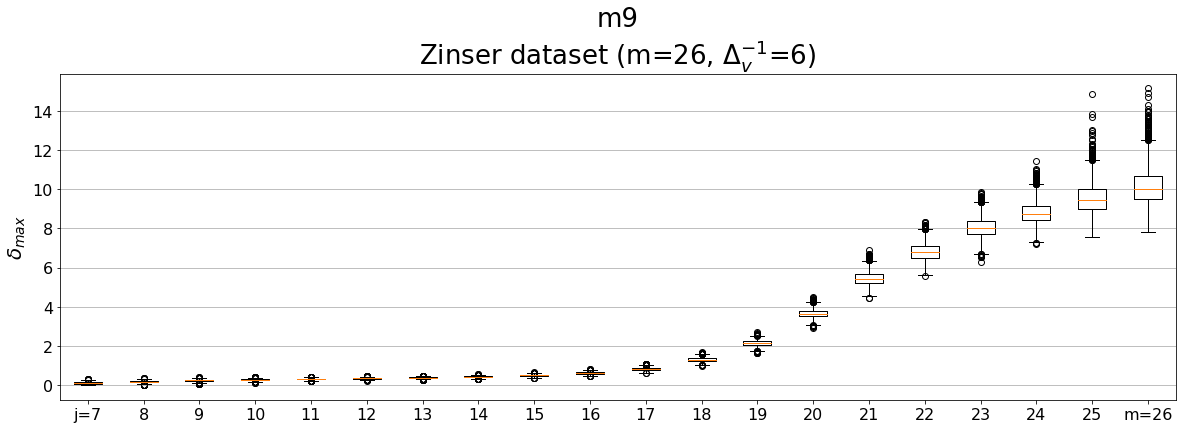

In [32]:
for dataname in data:
    for model,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[model] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[model][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

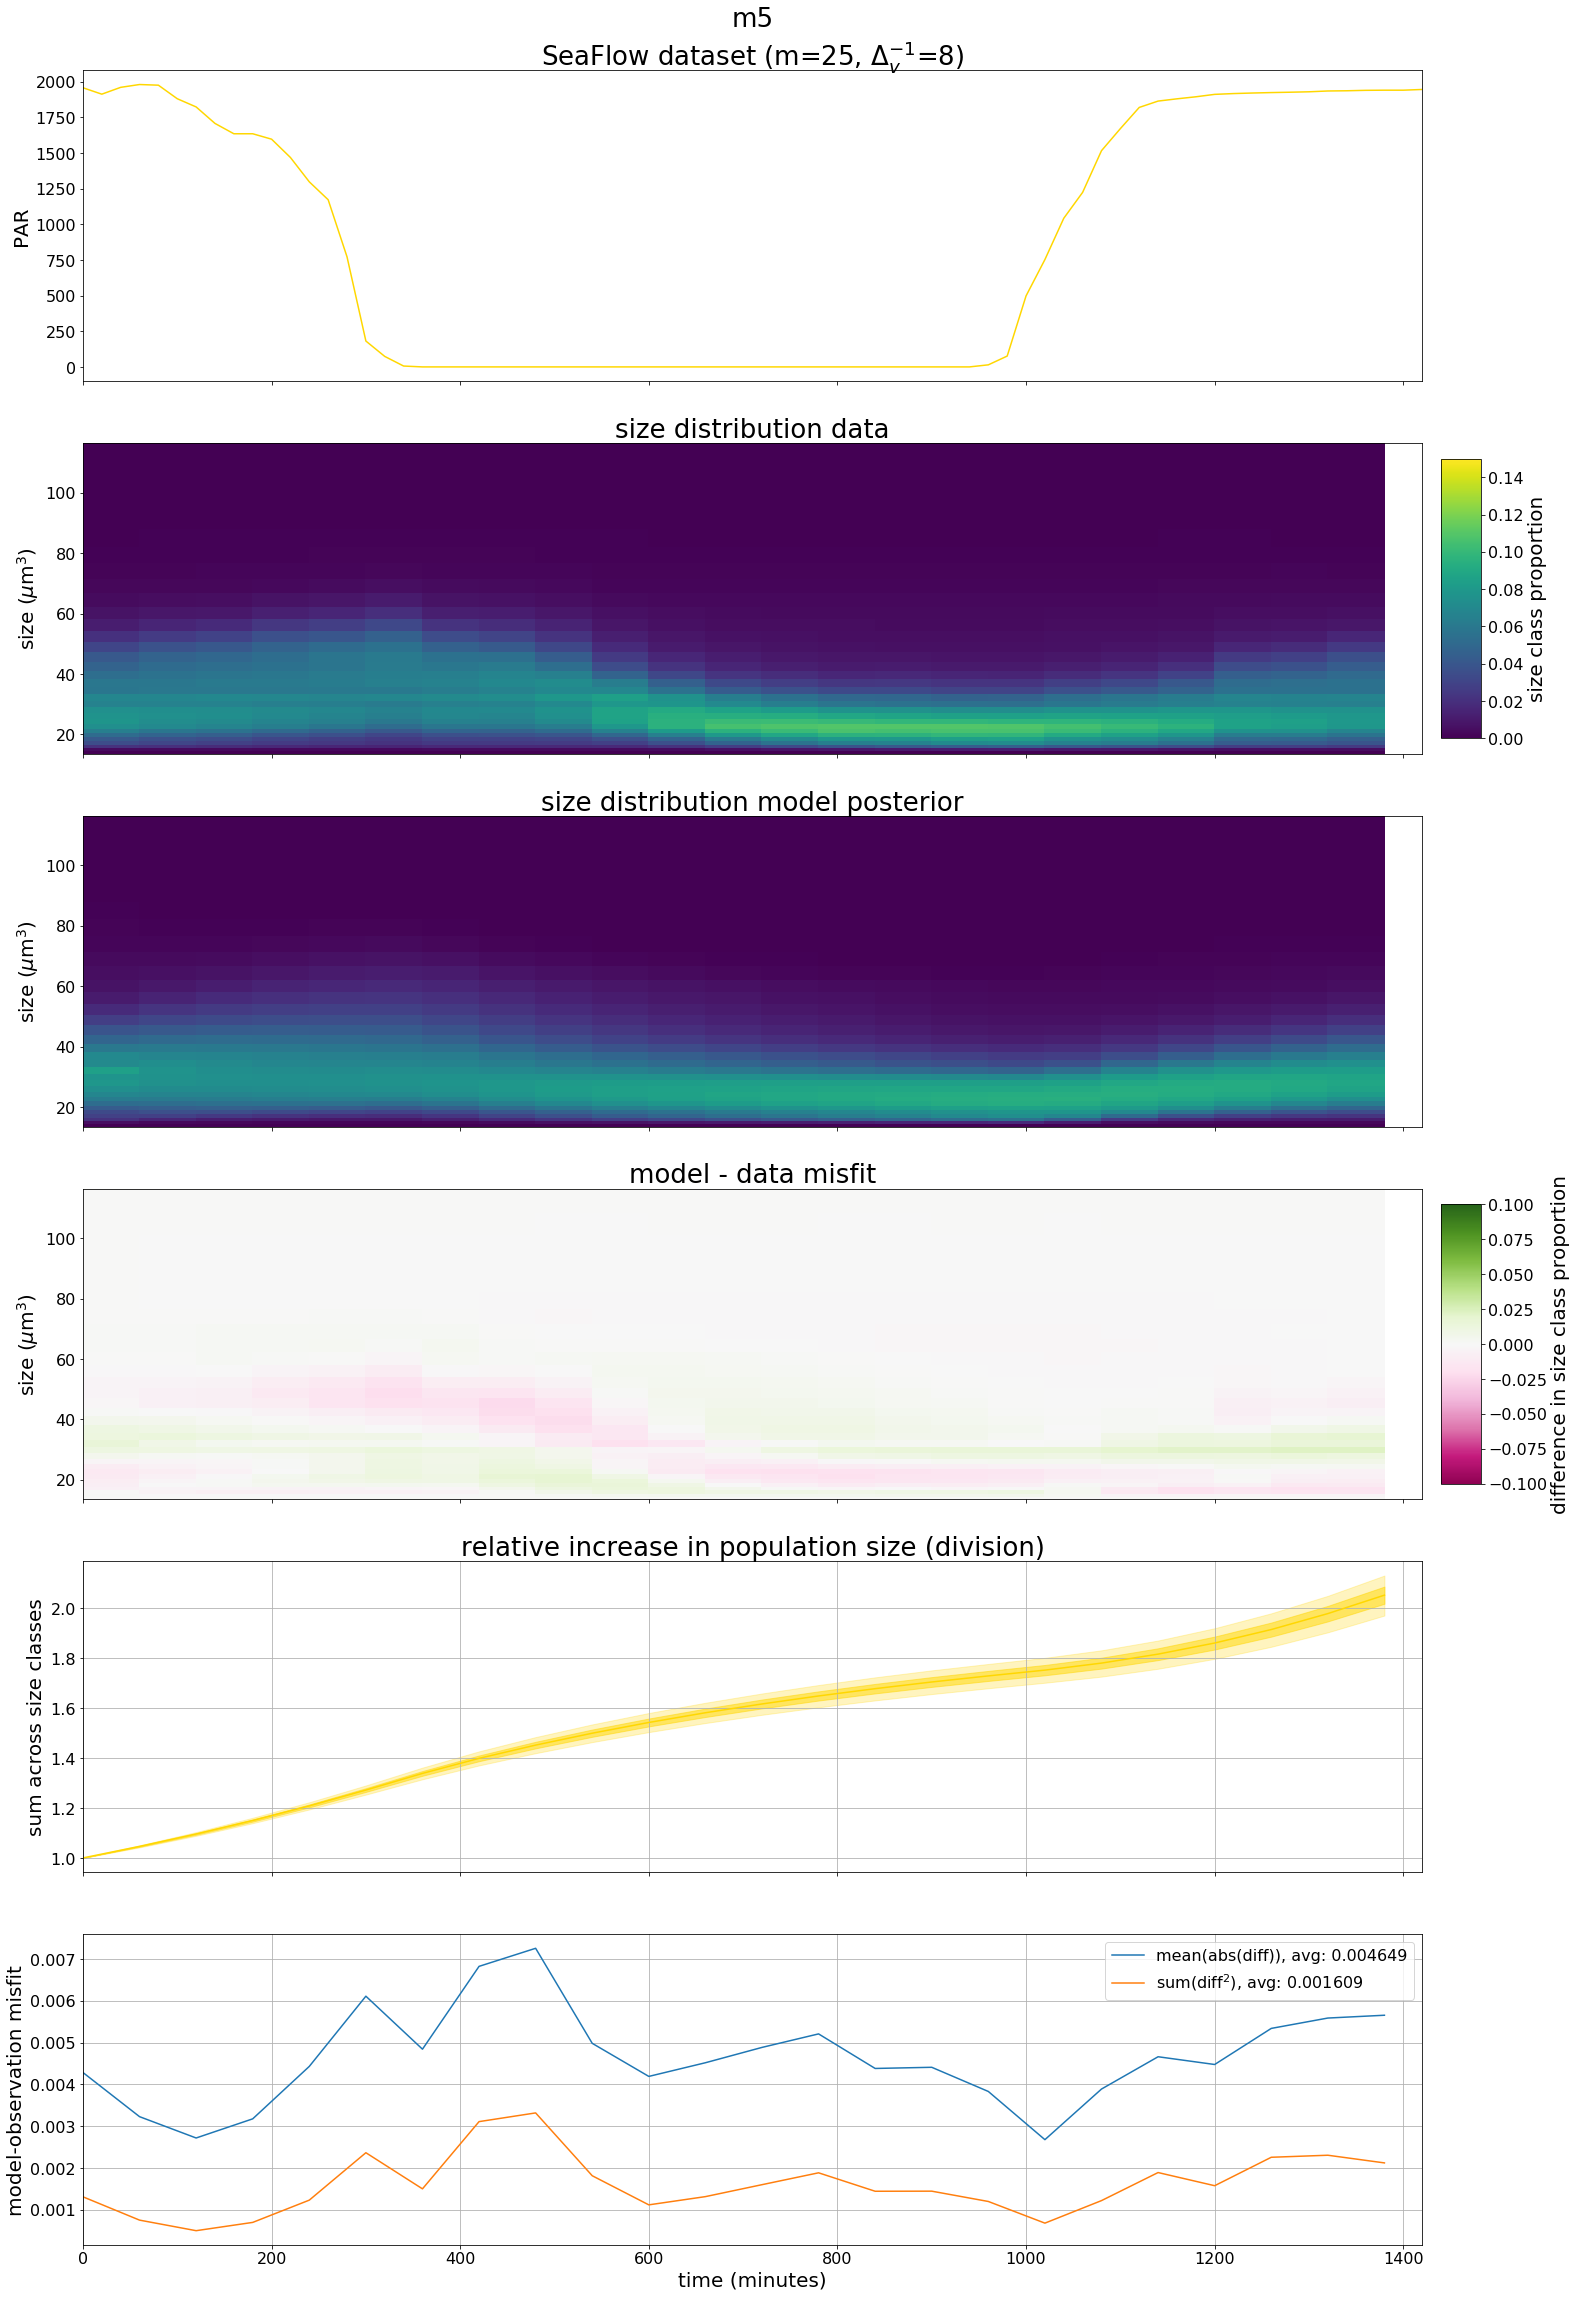

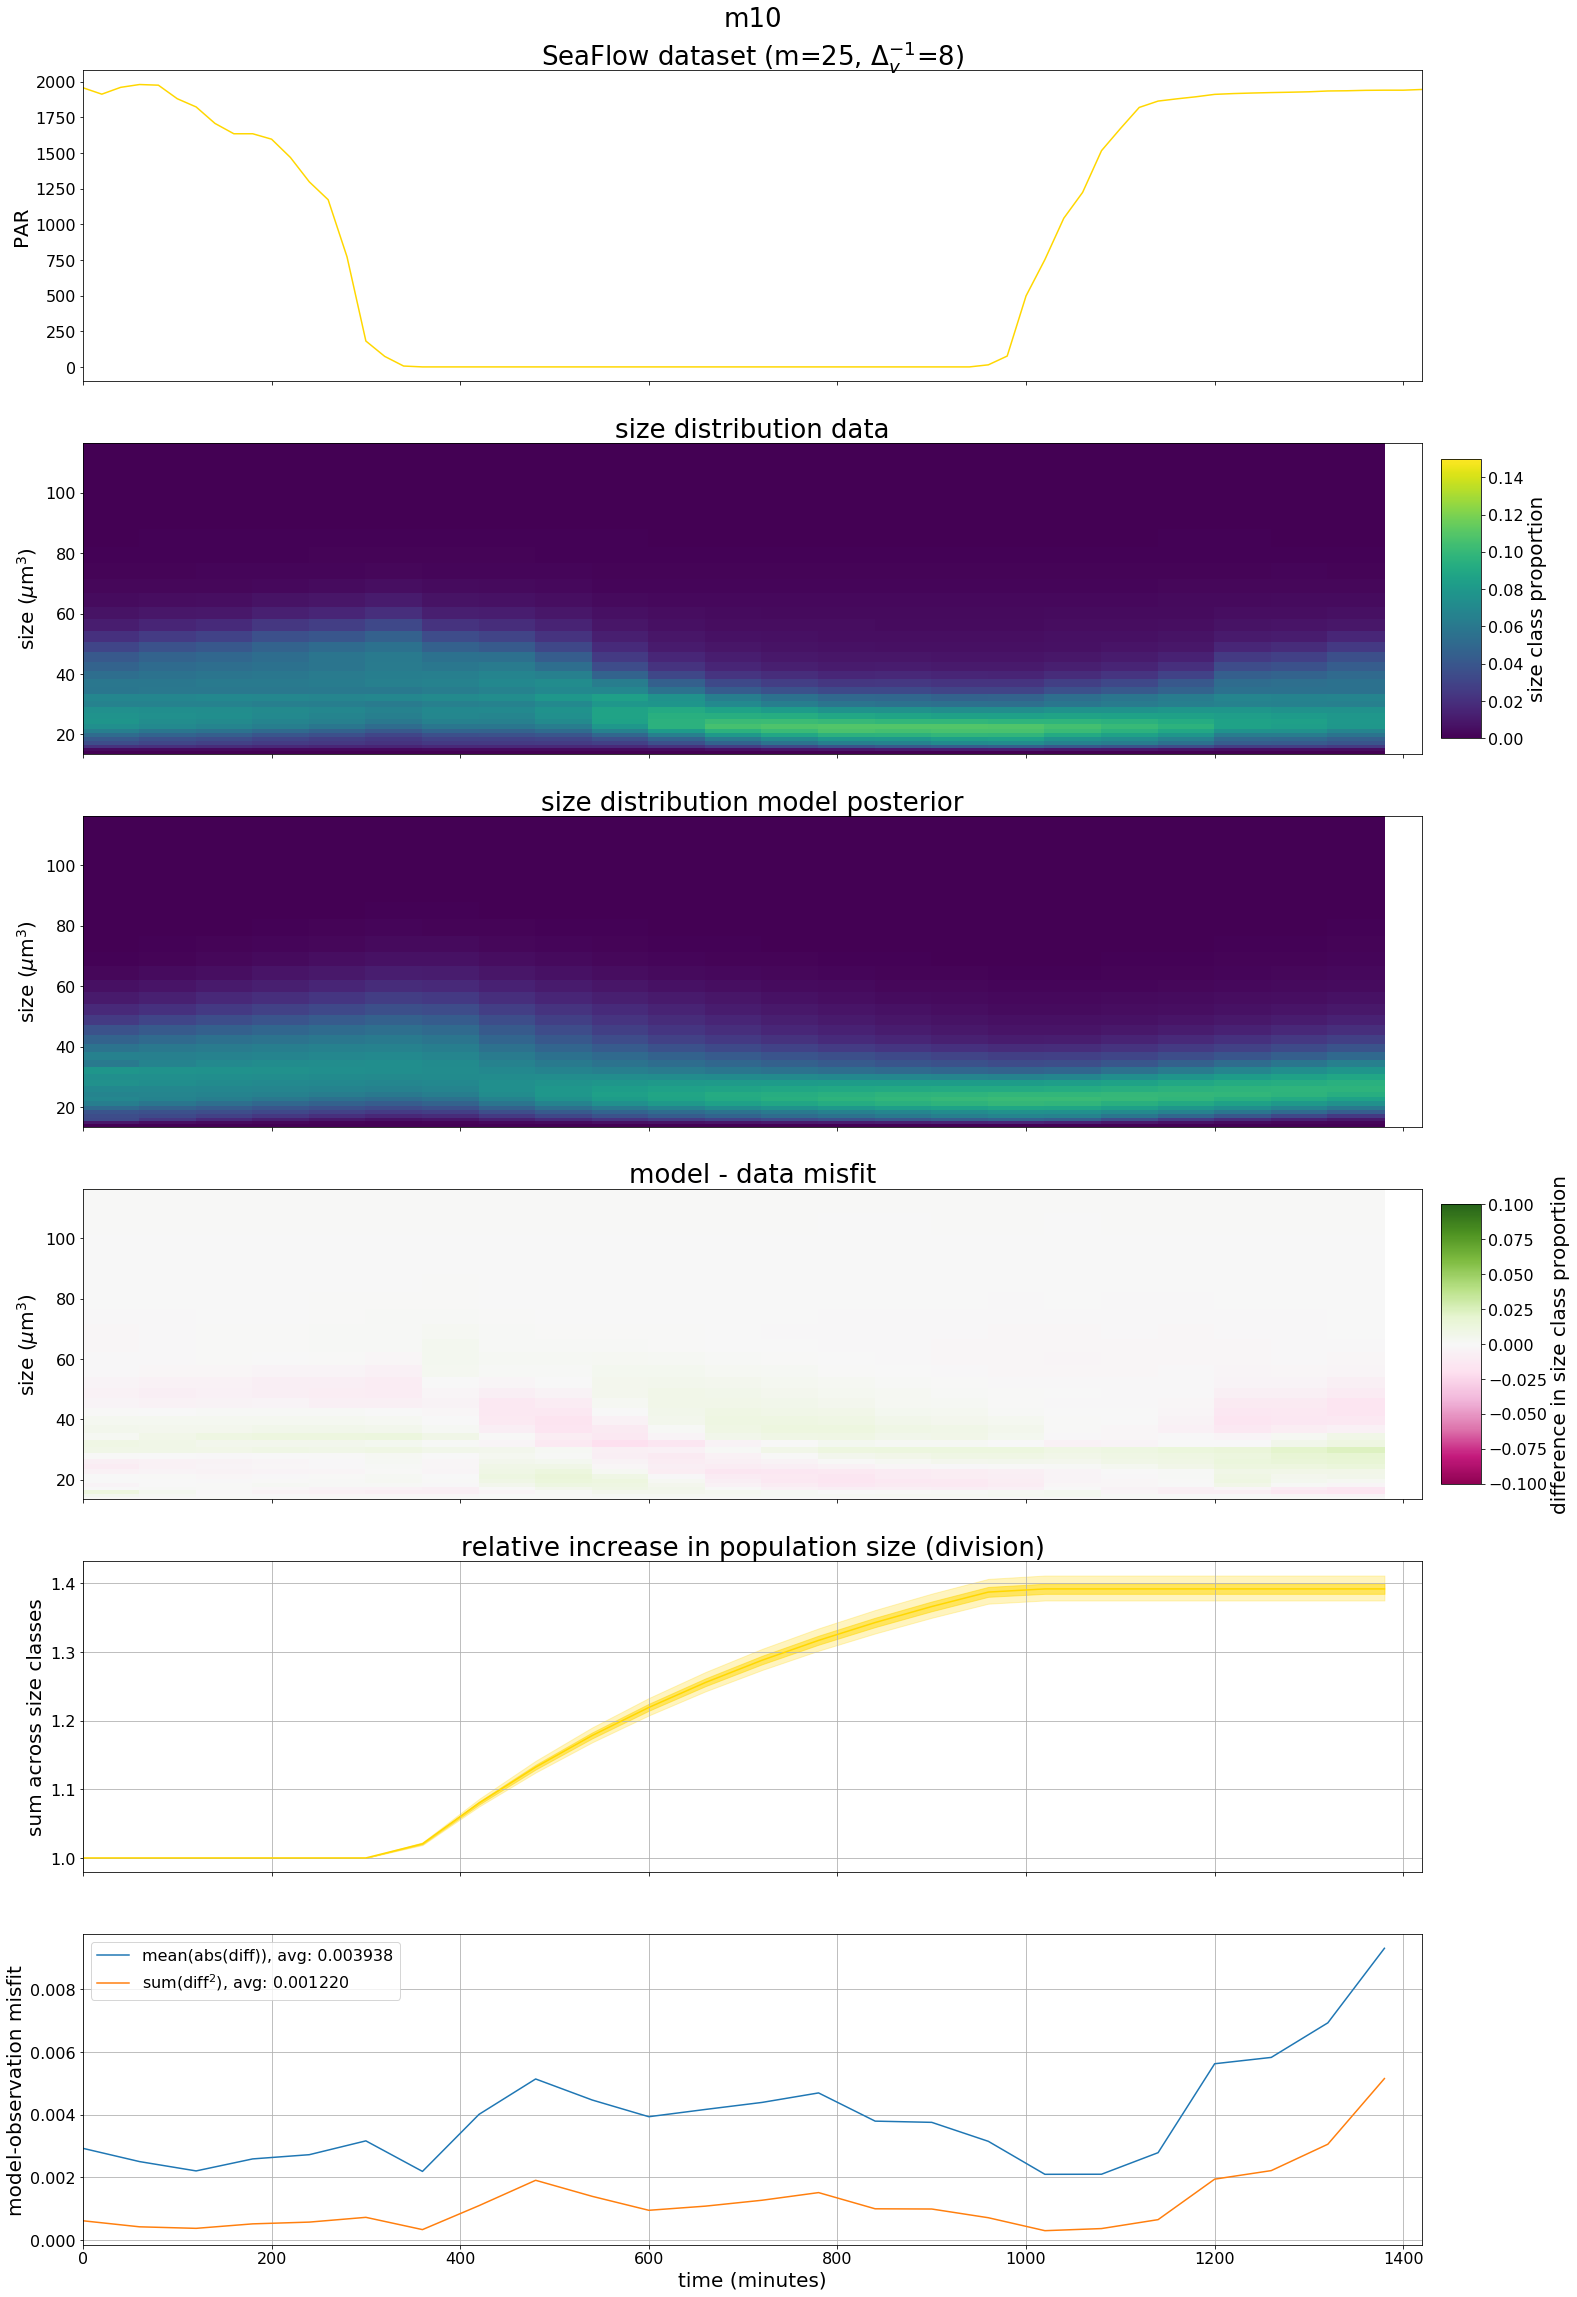

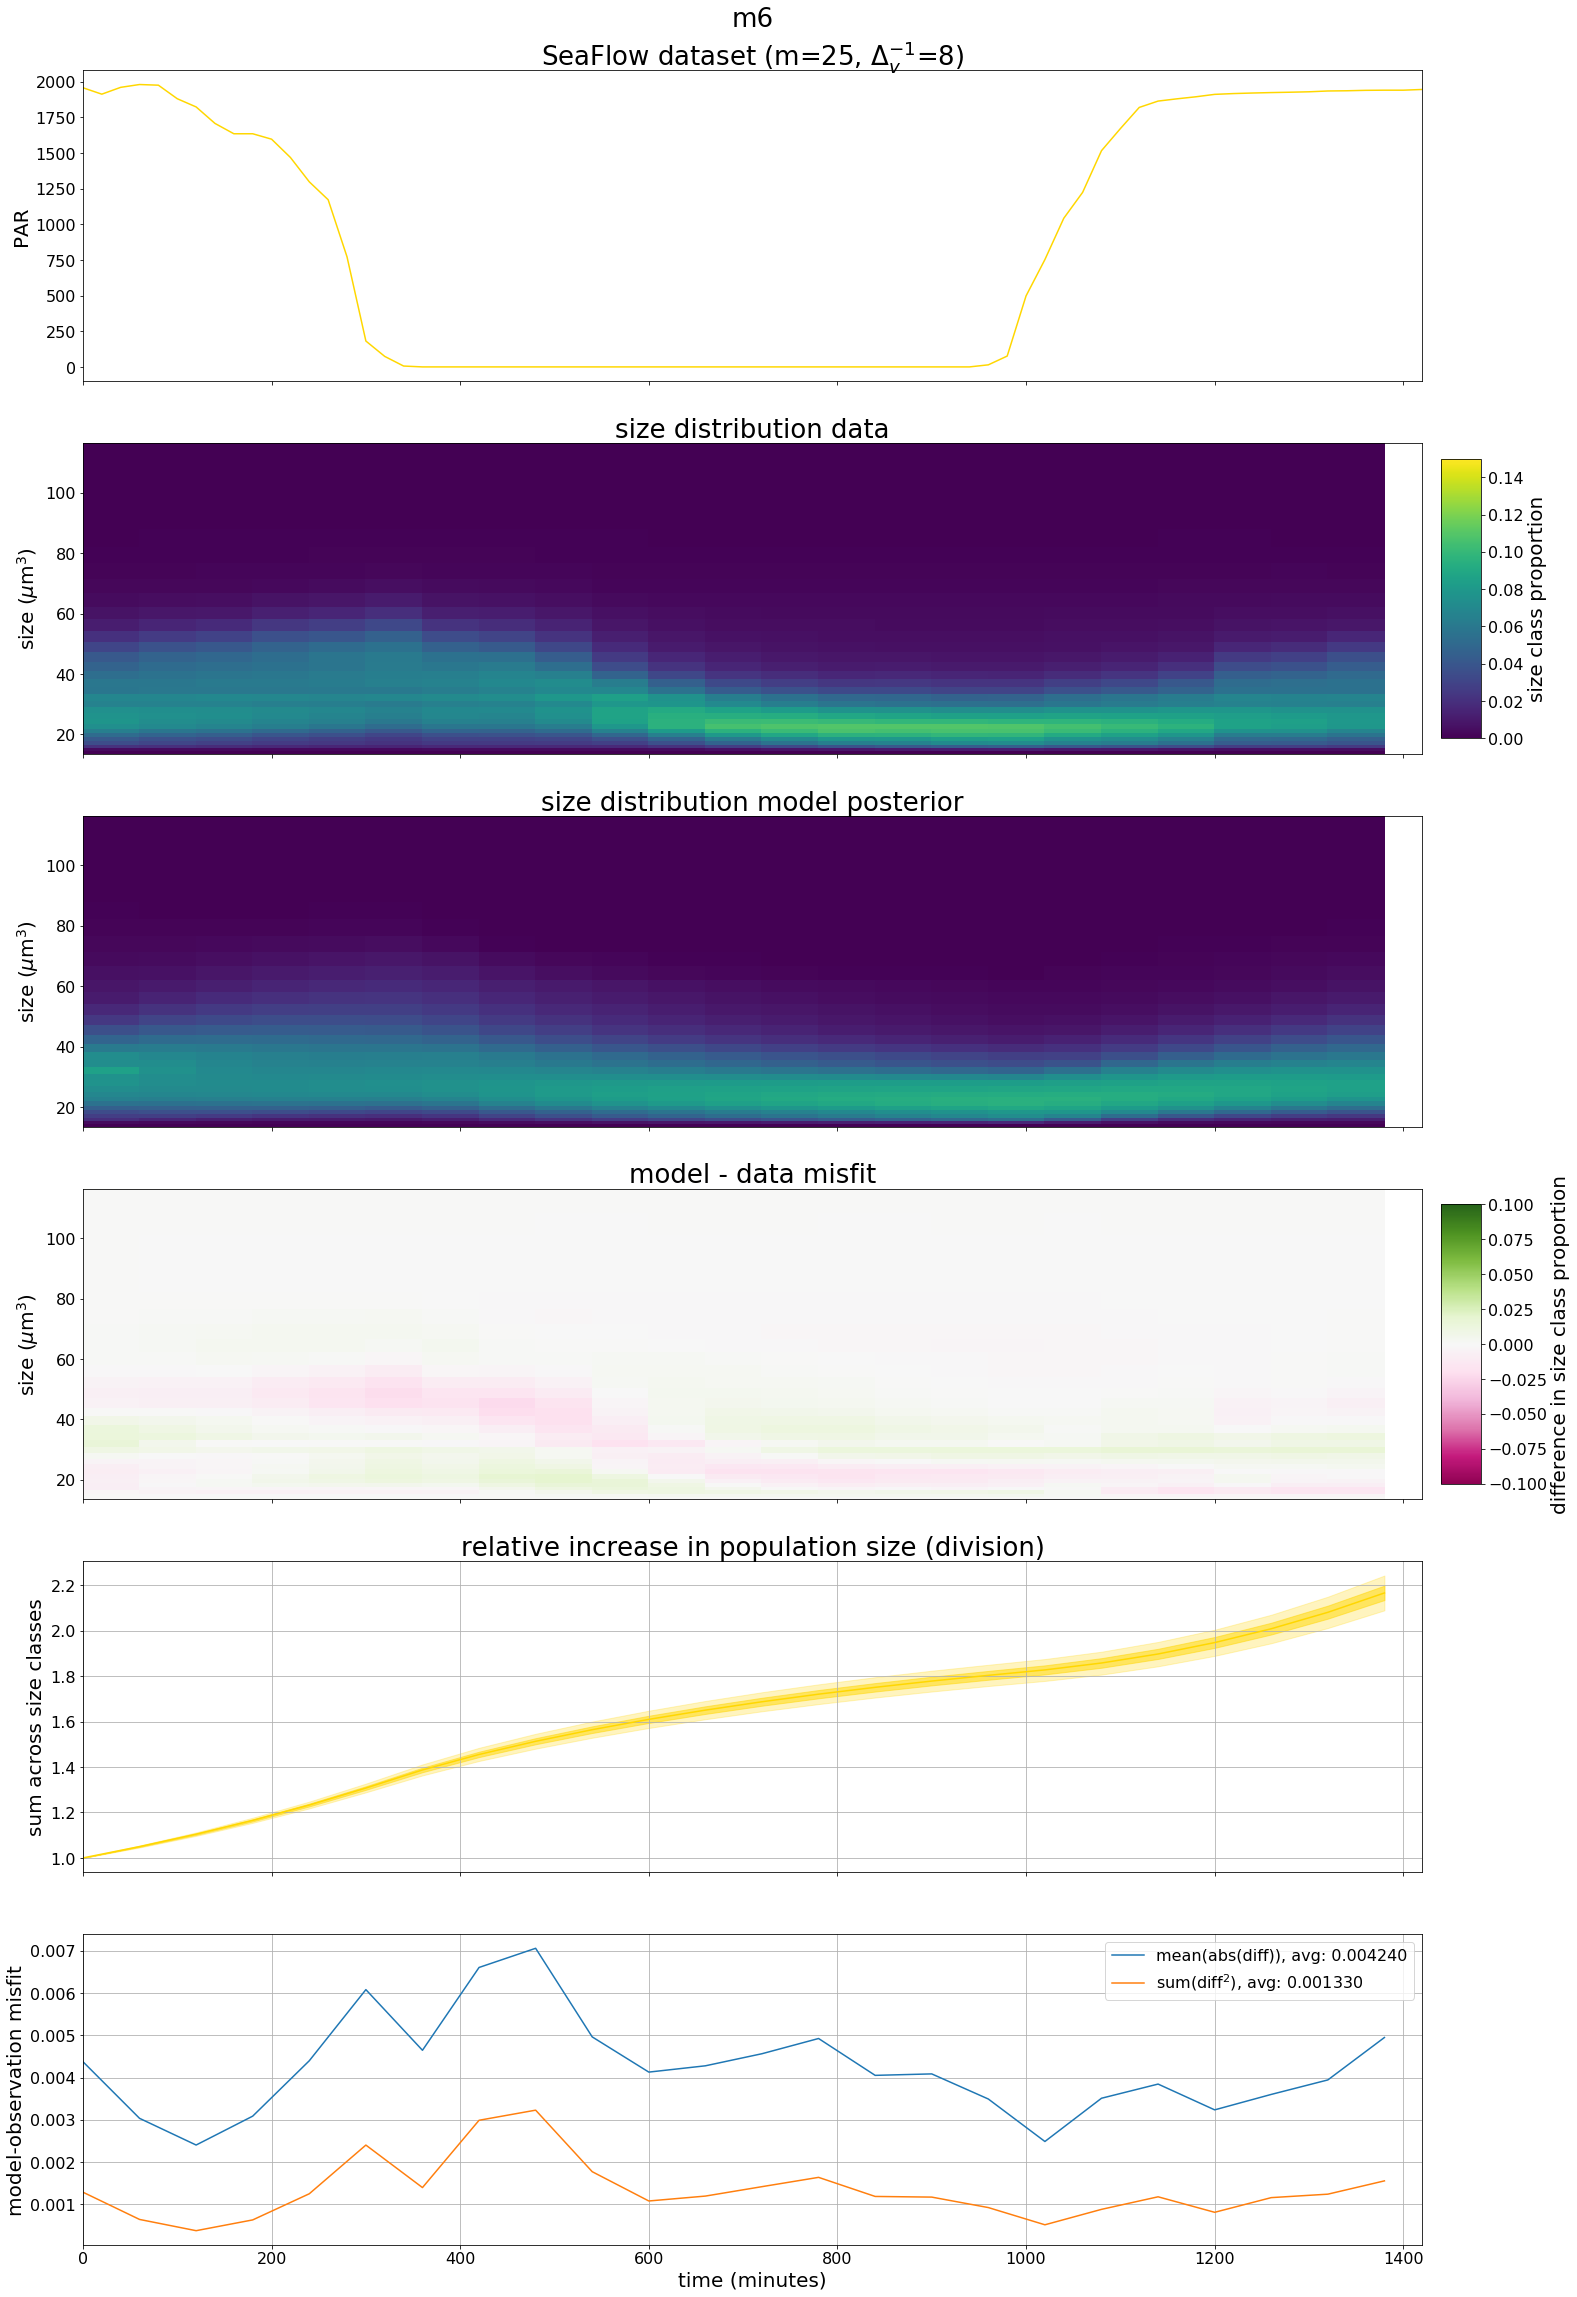

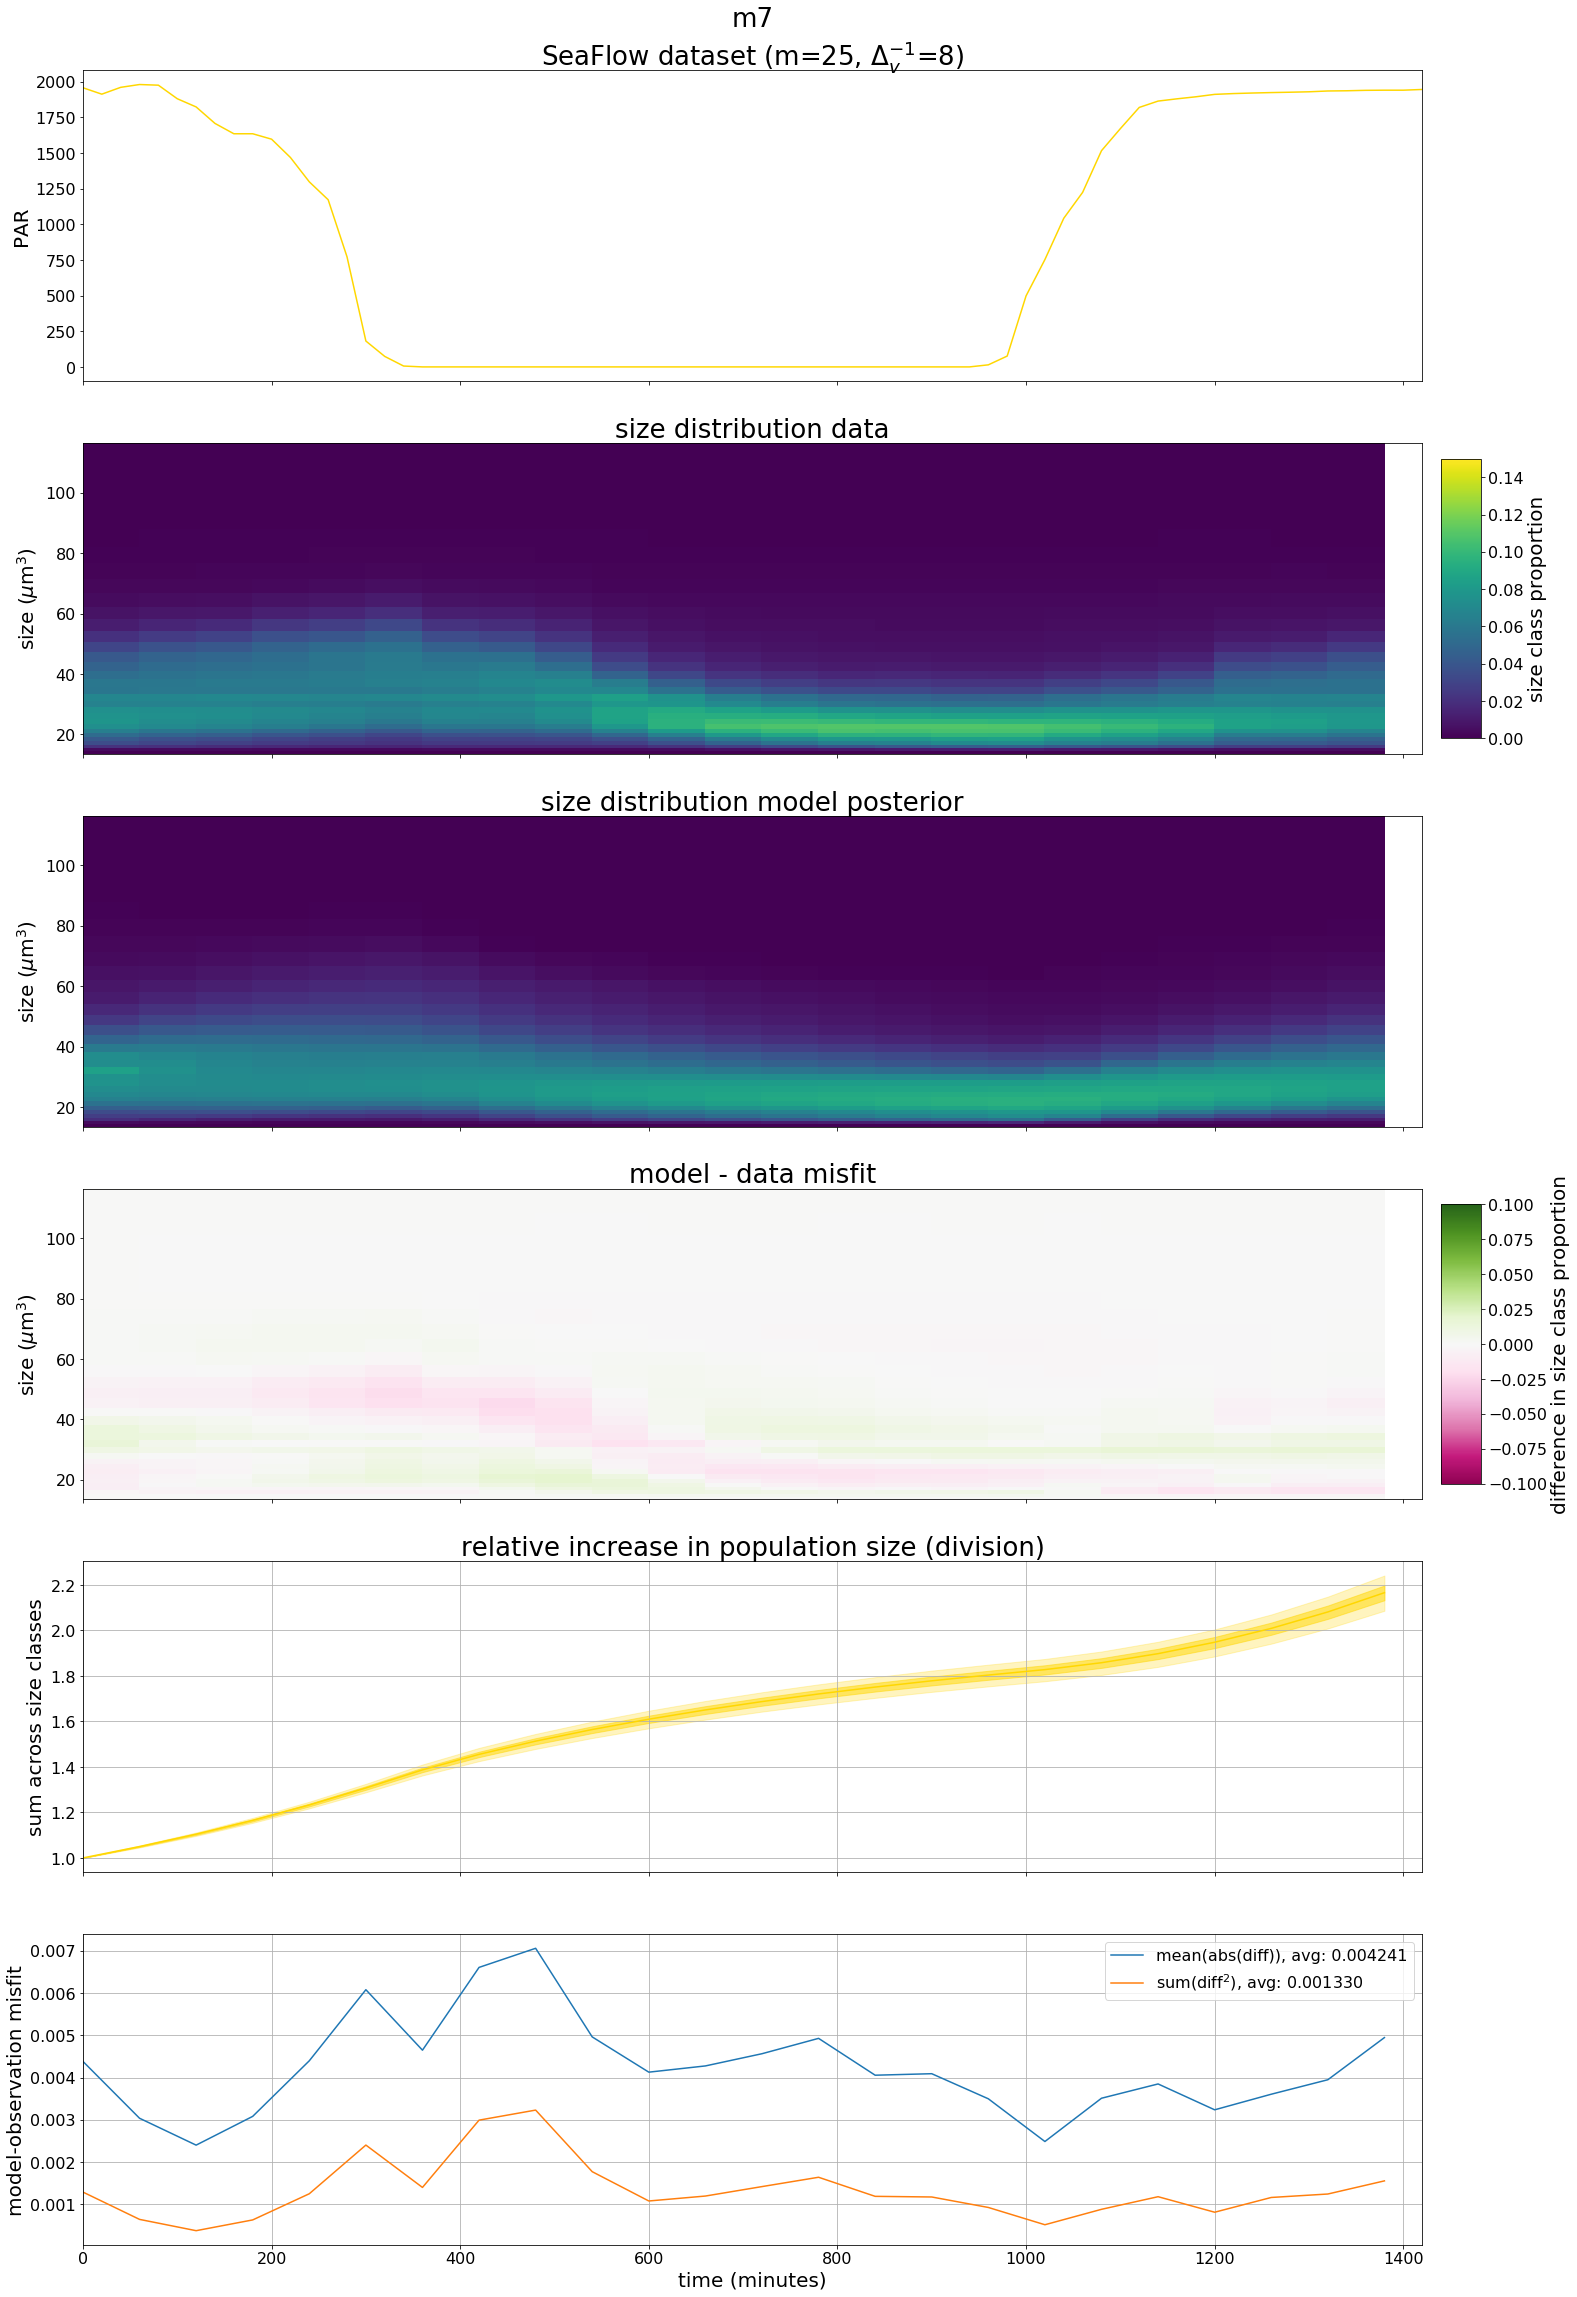

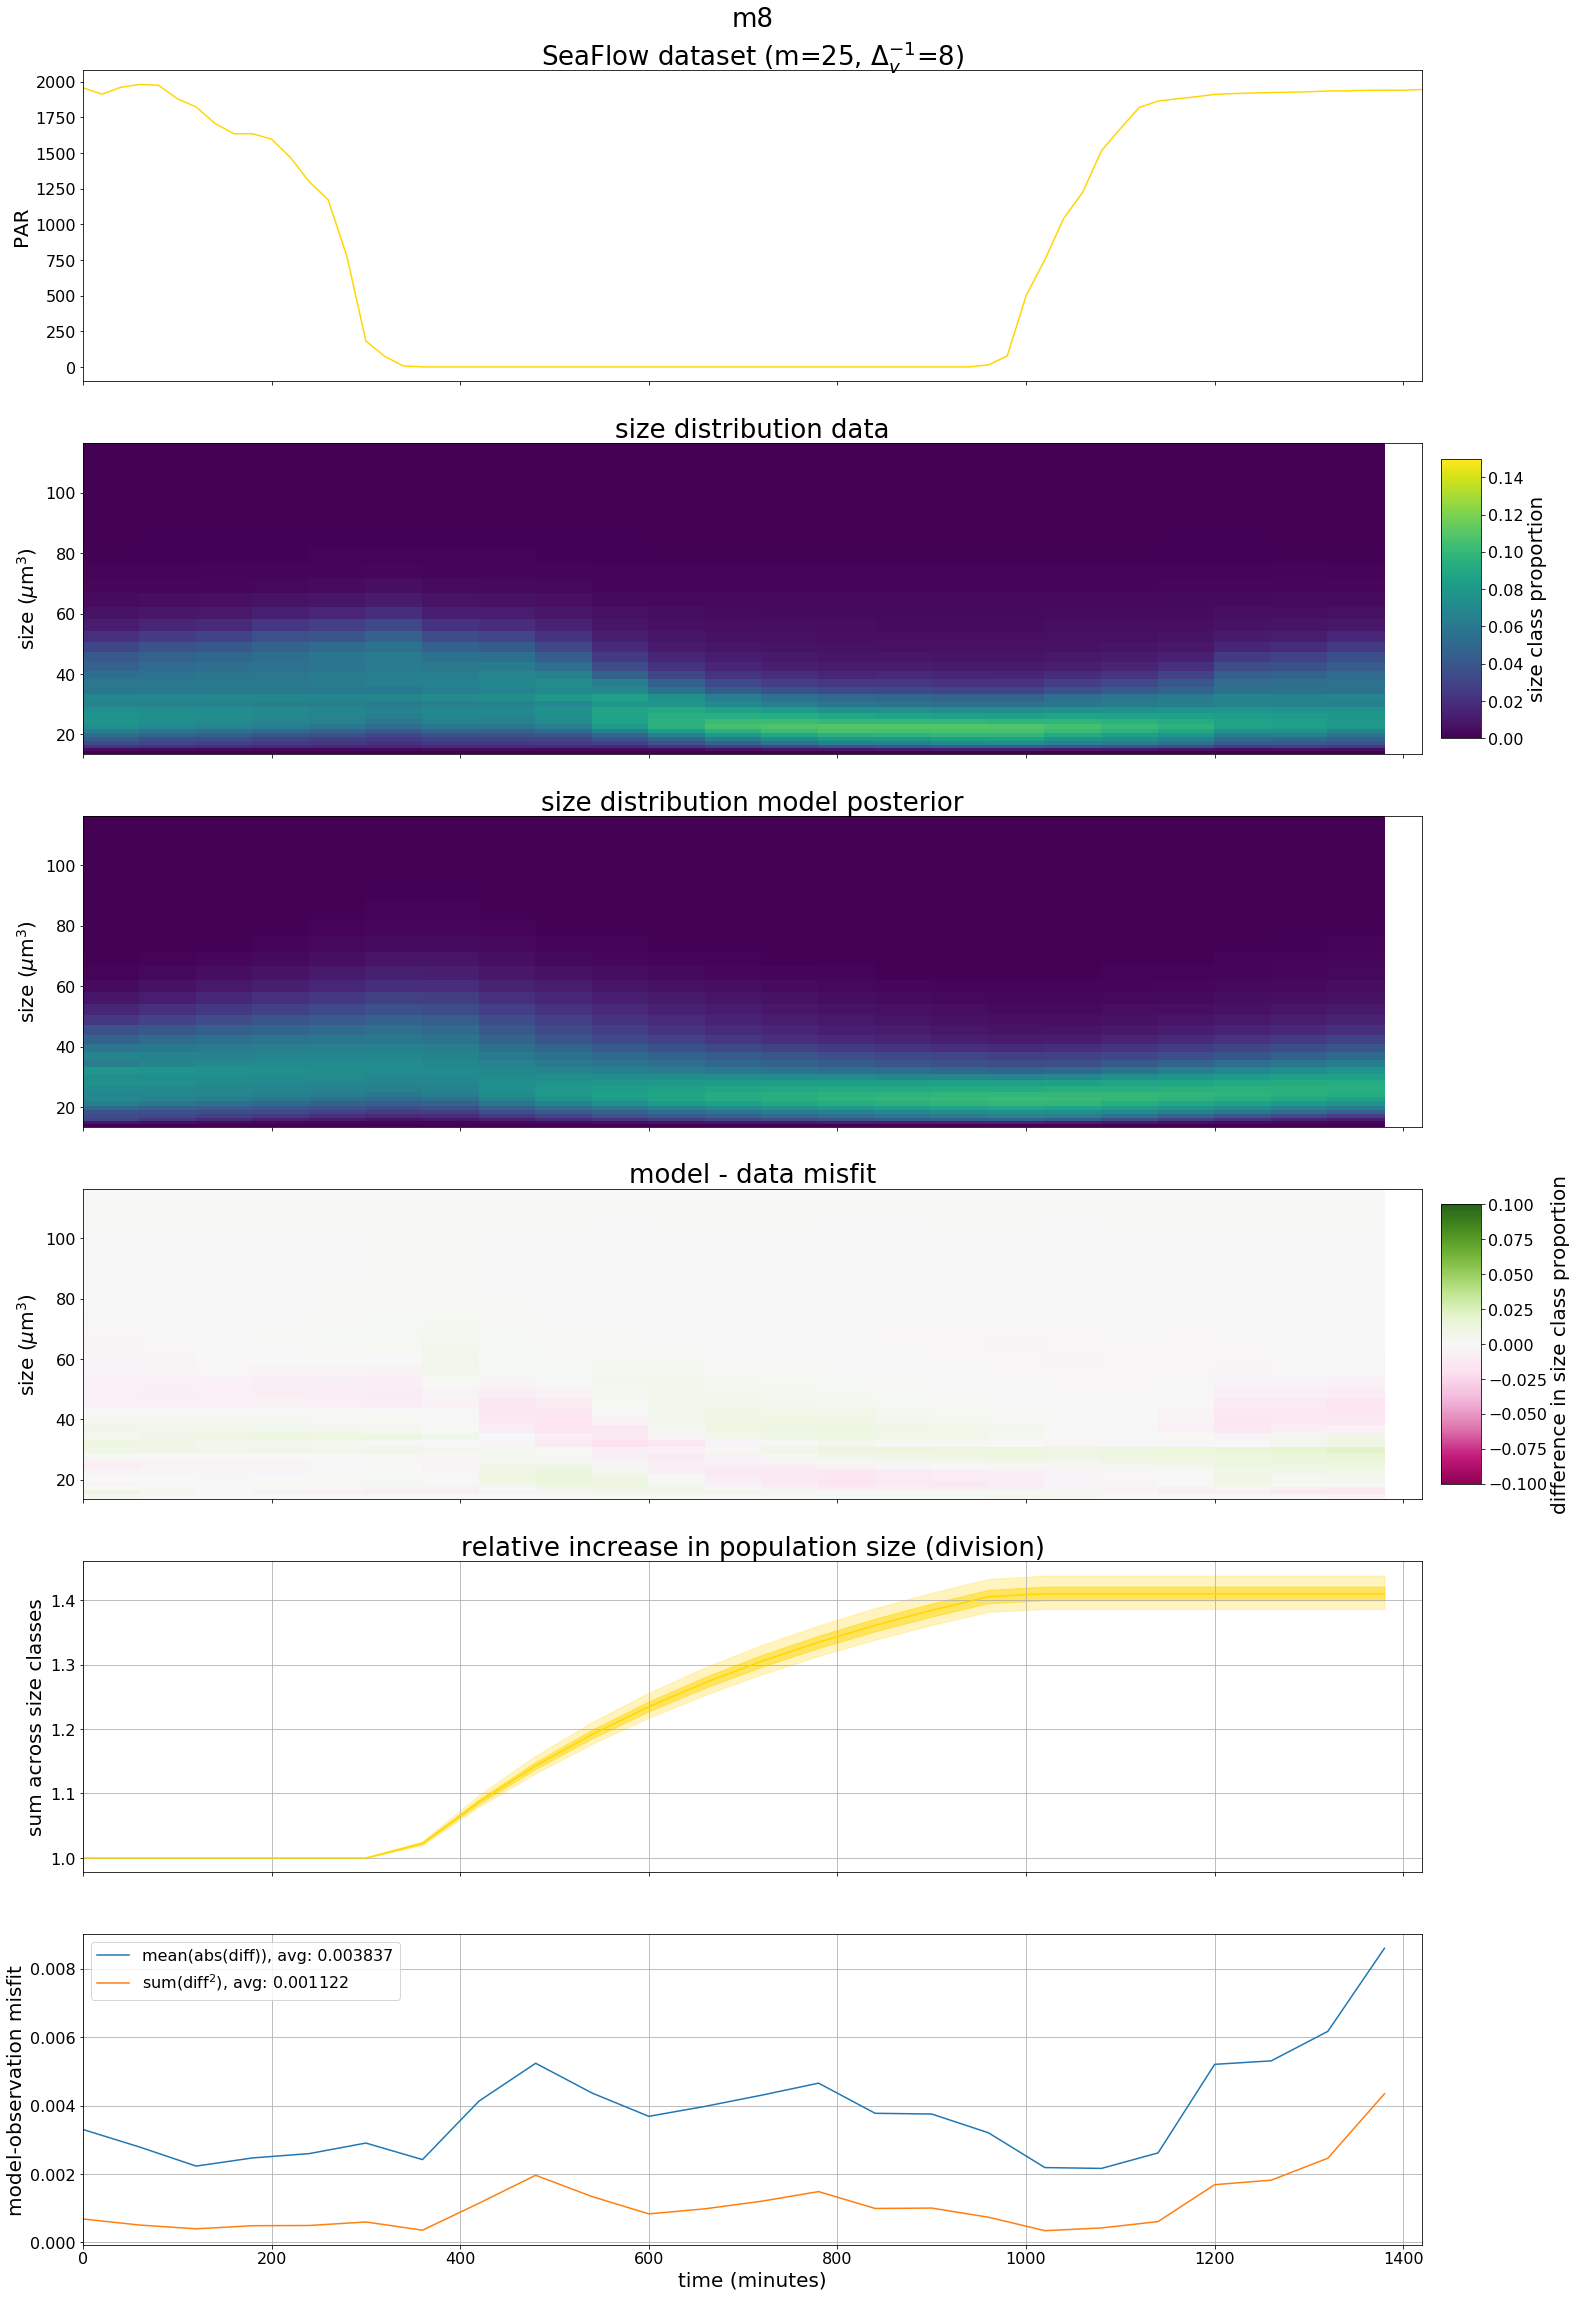

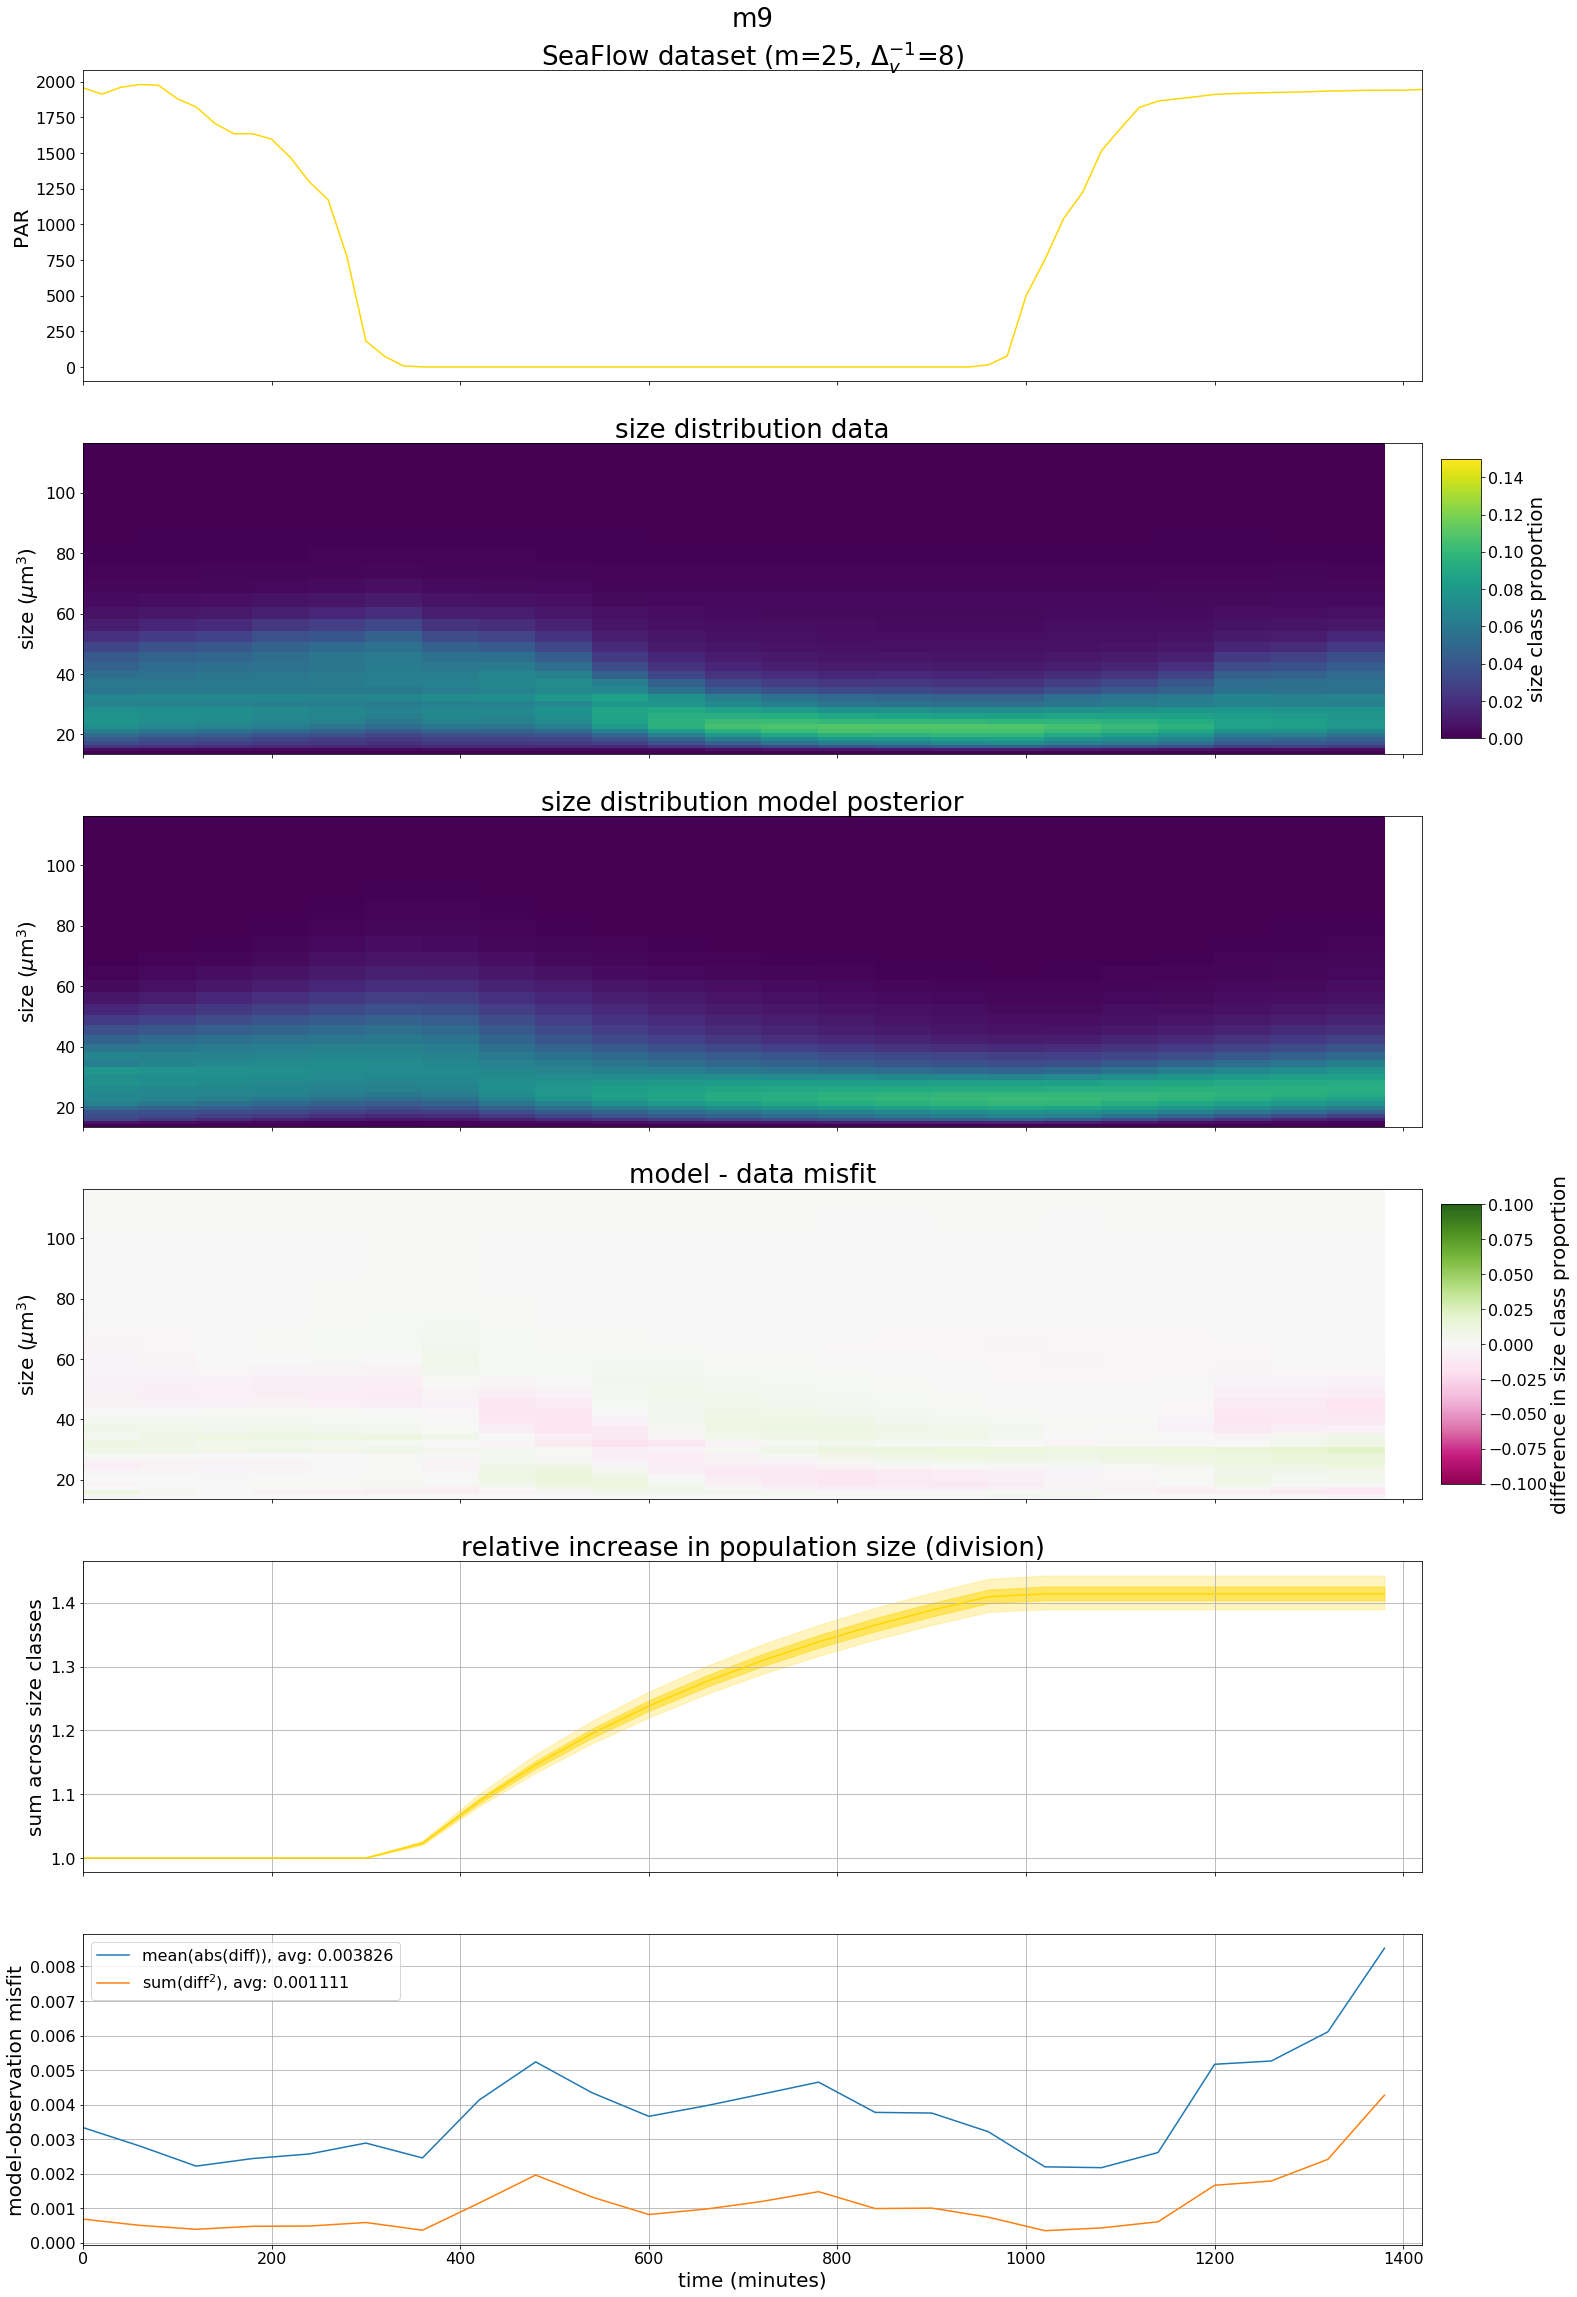

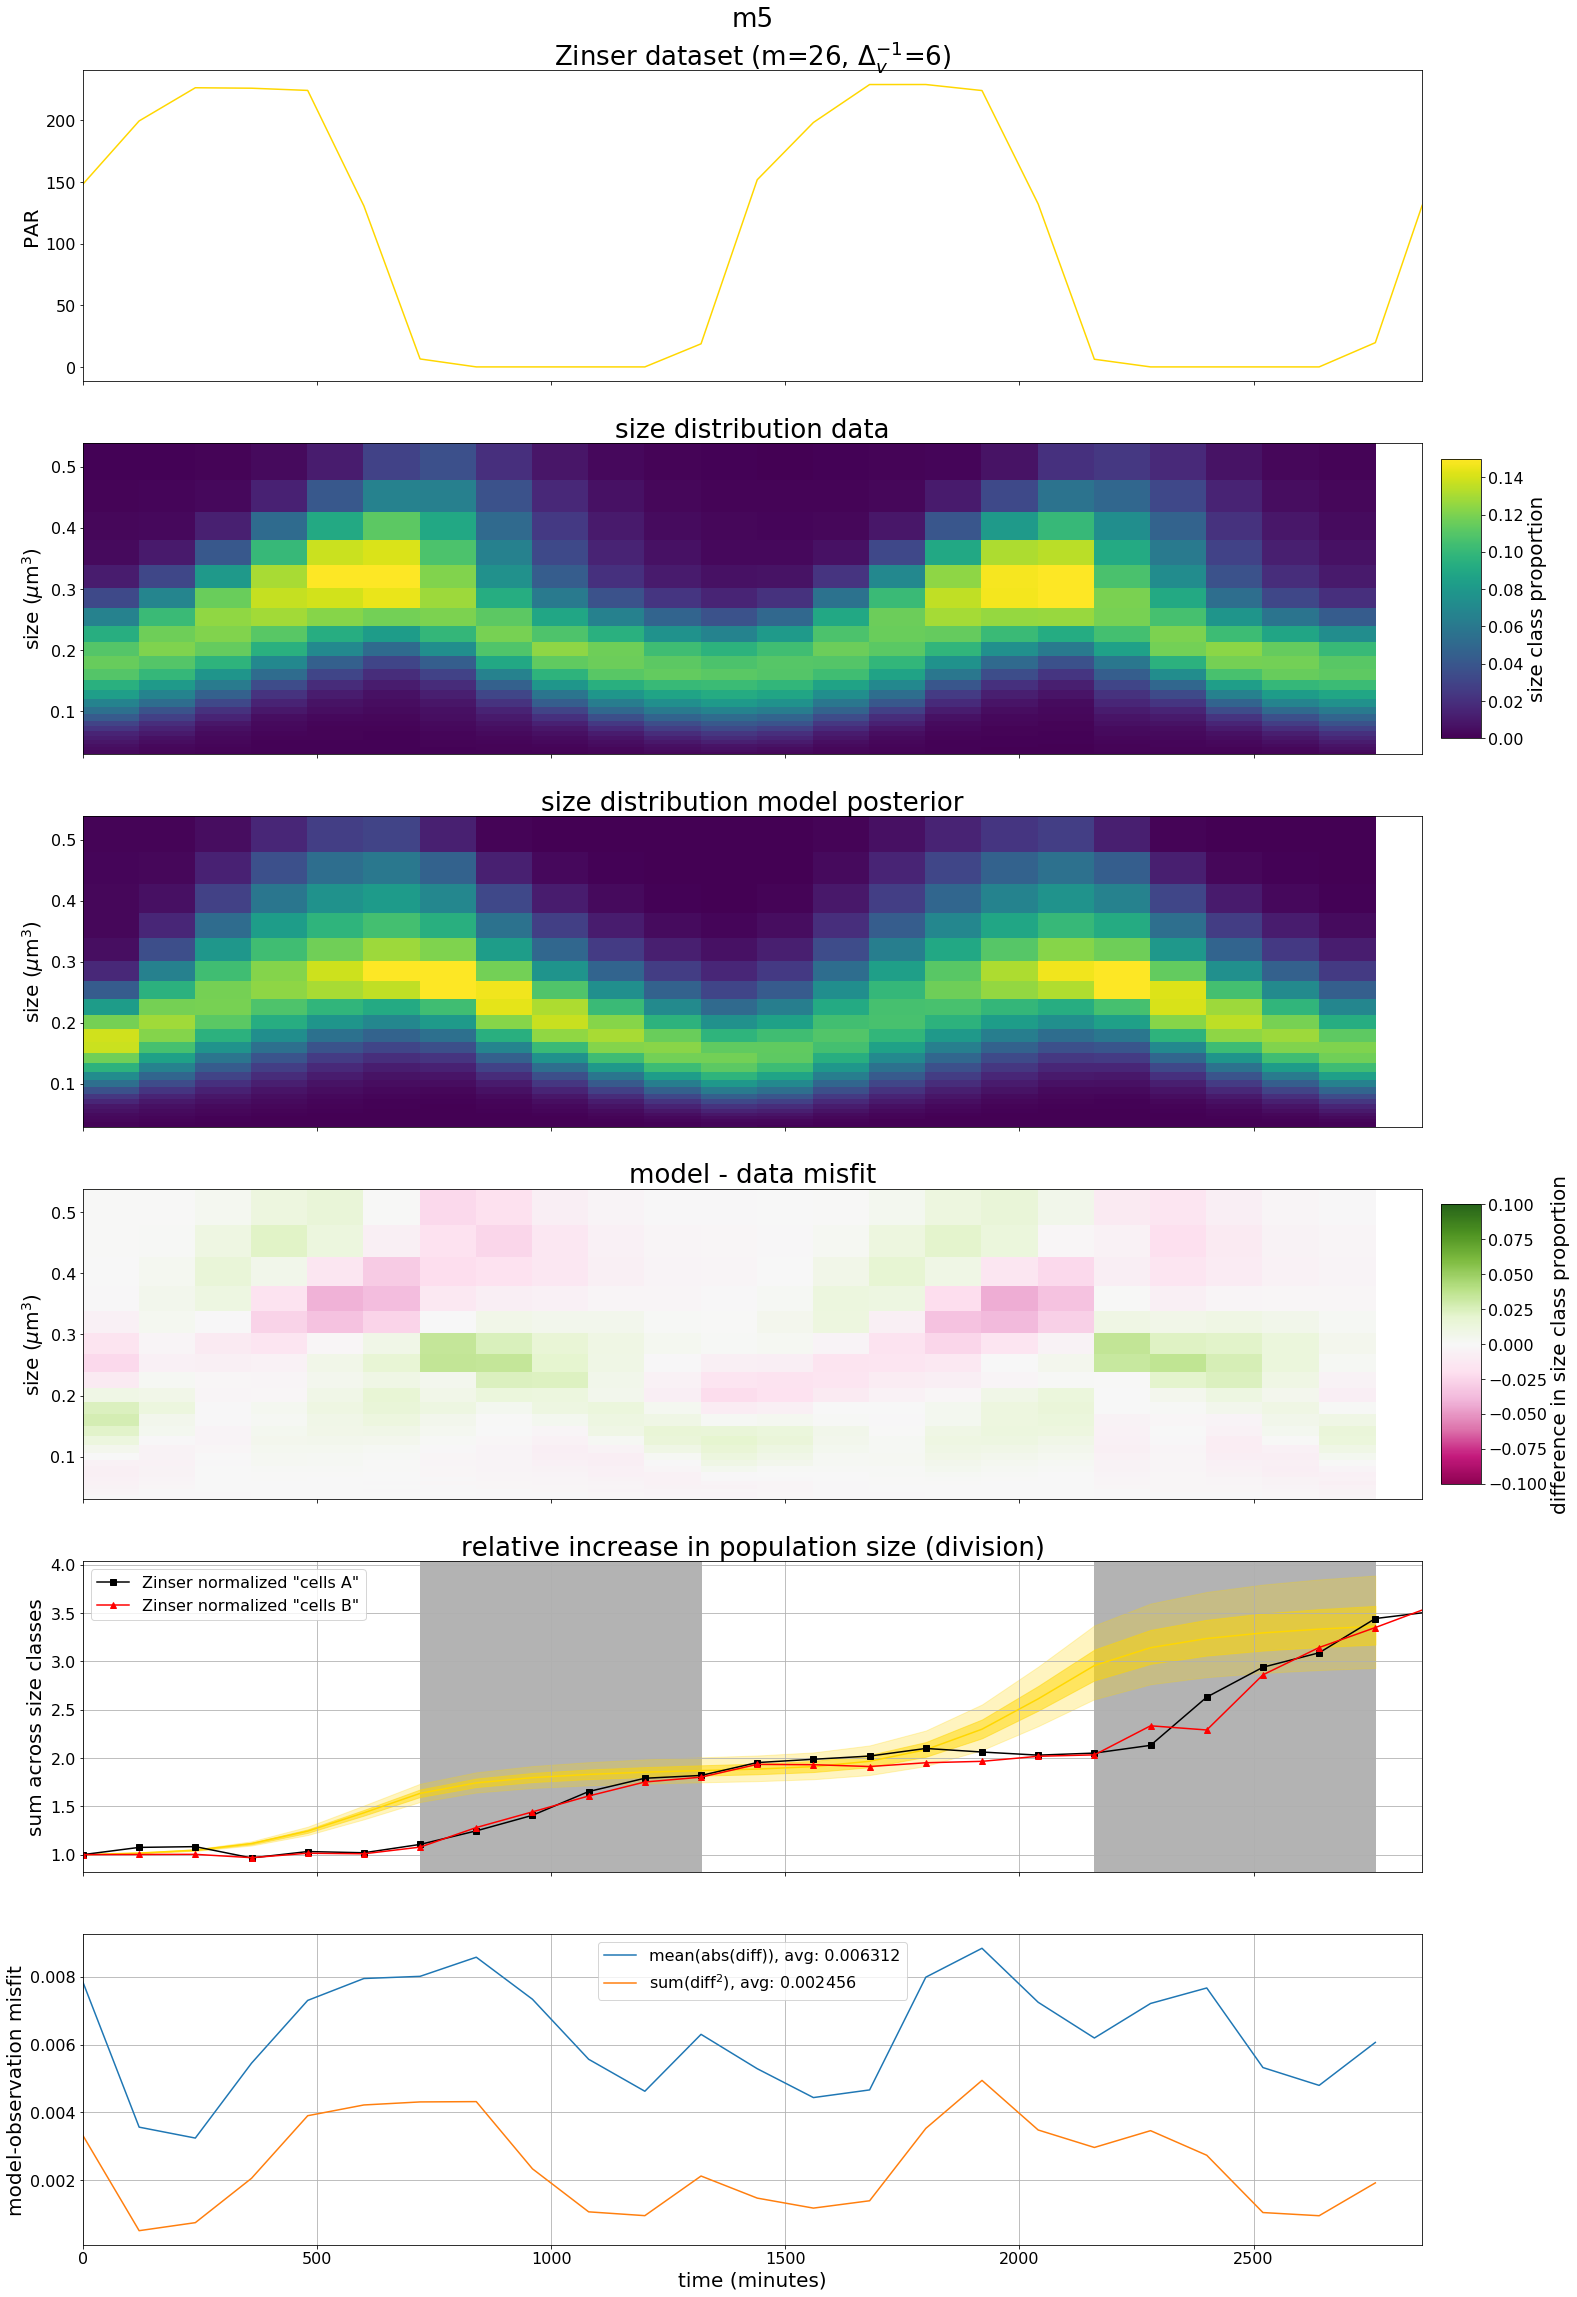

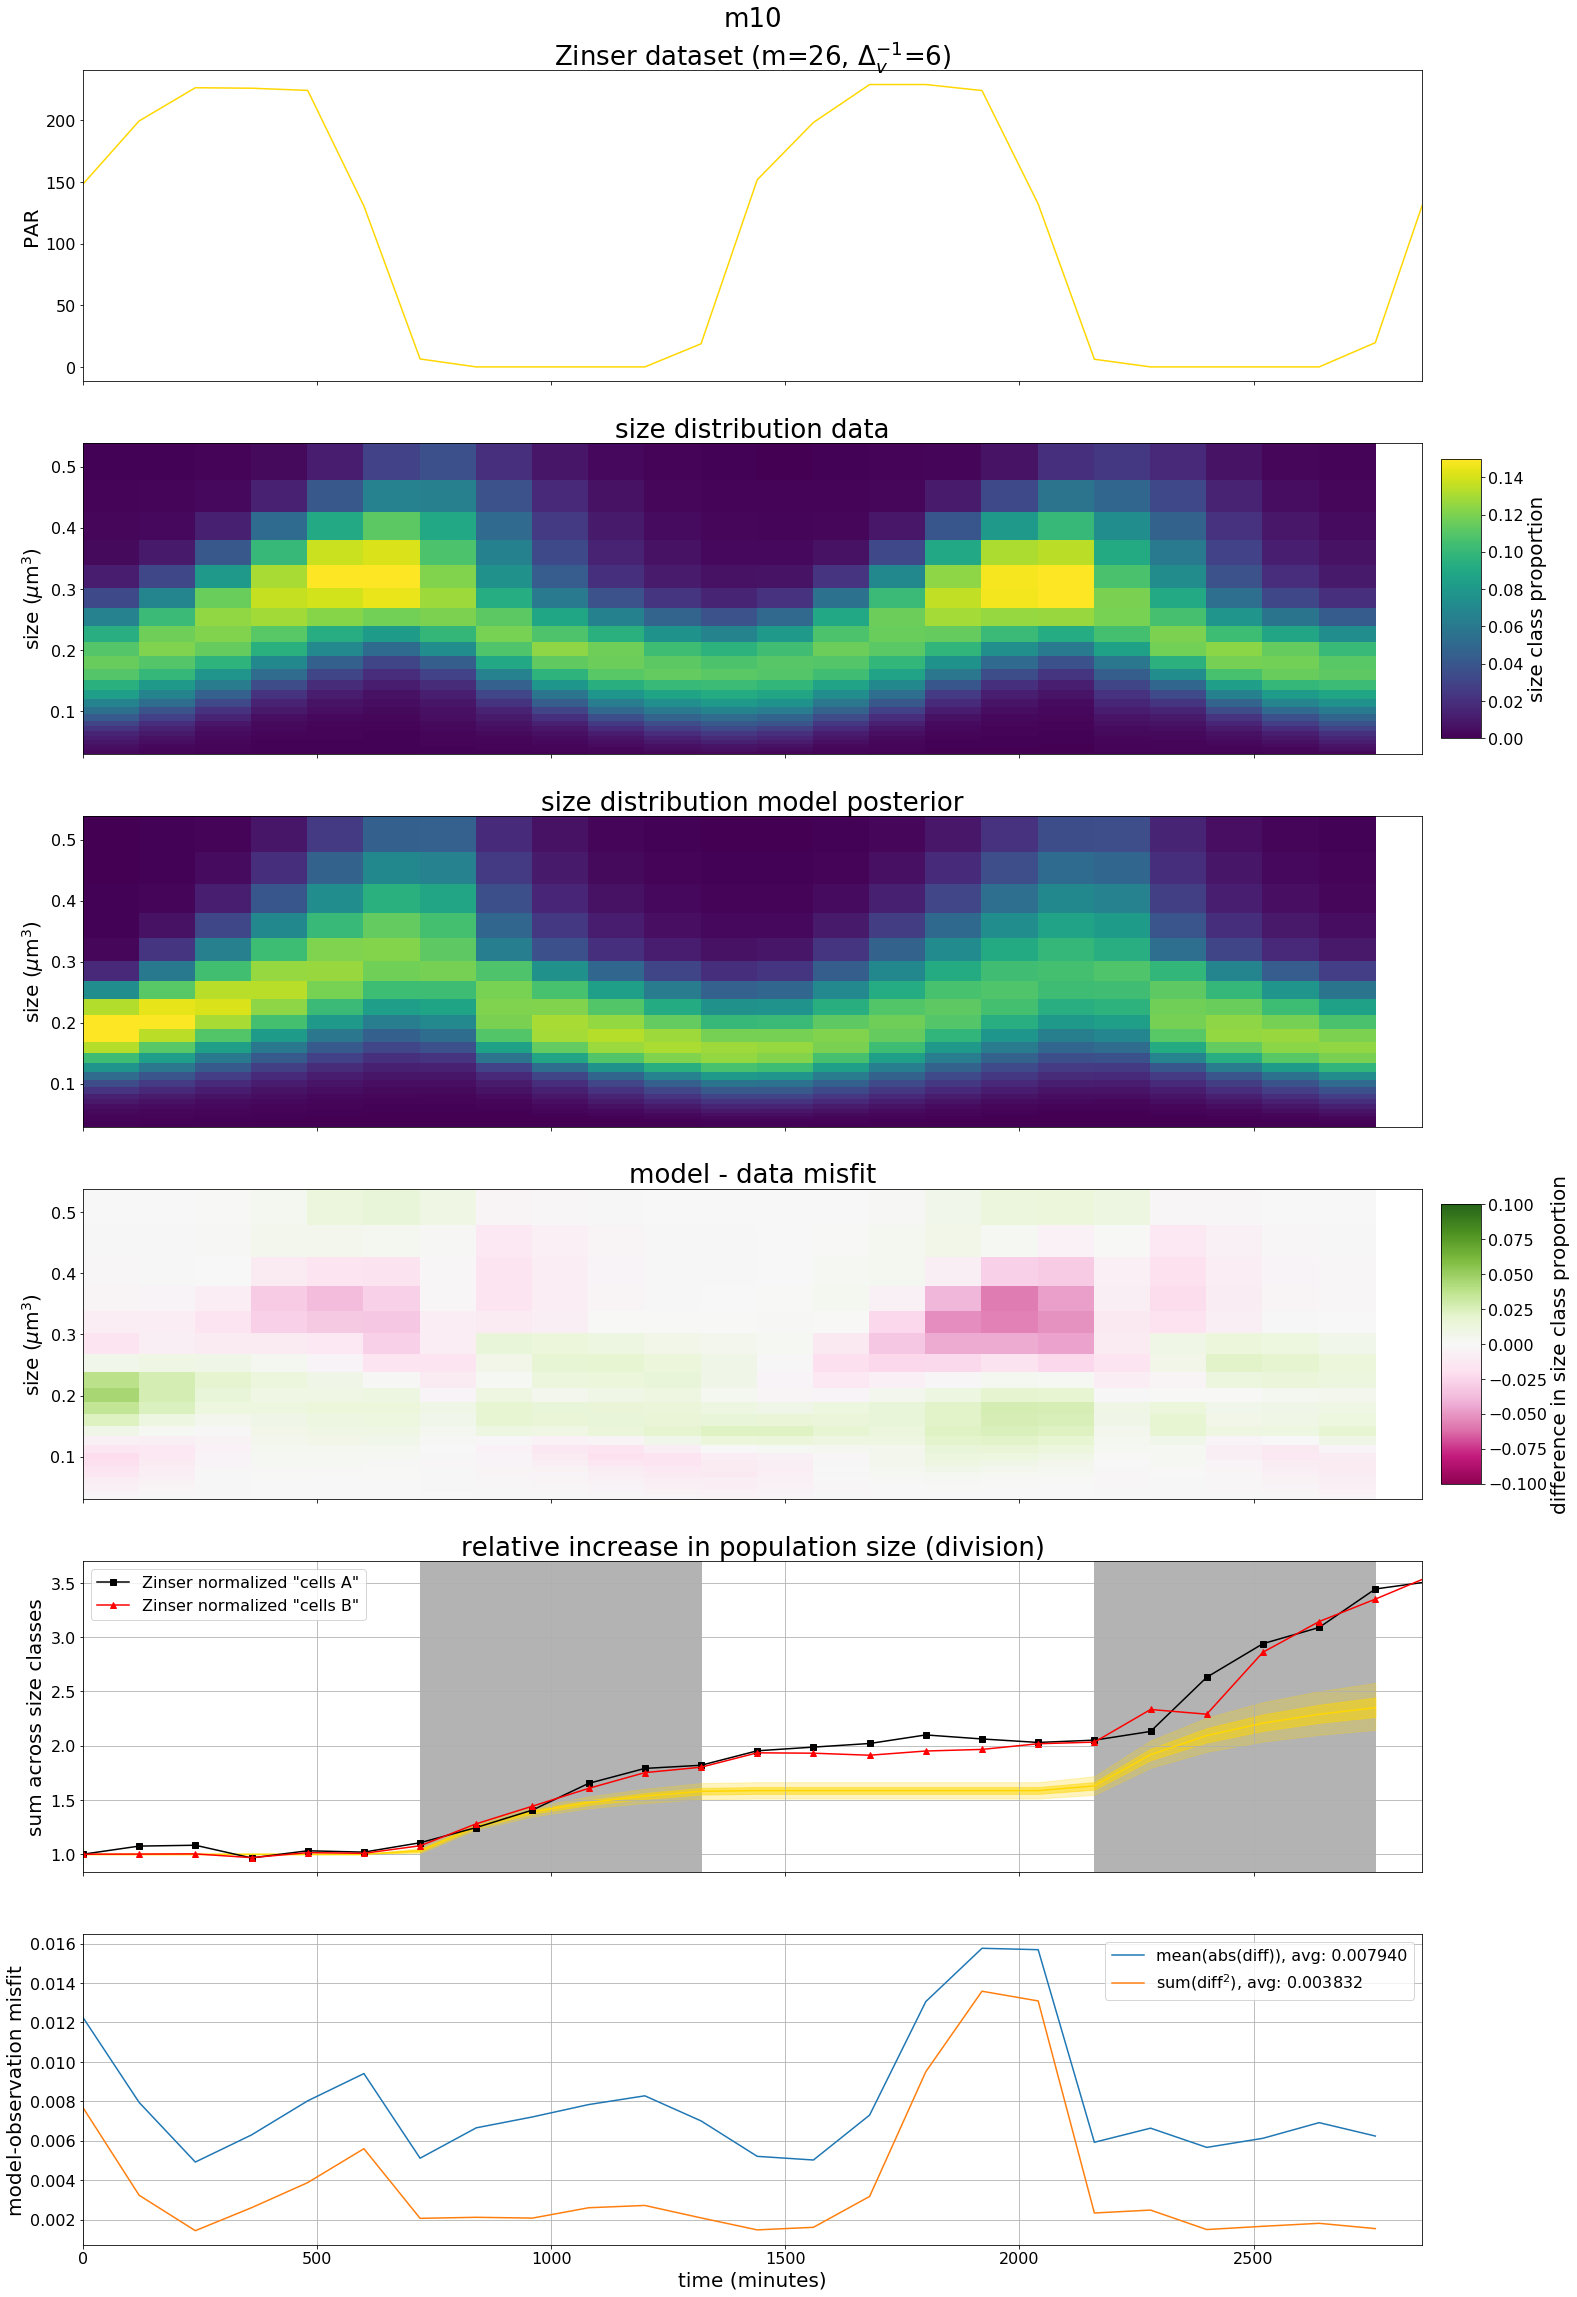

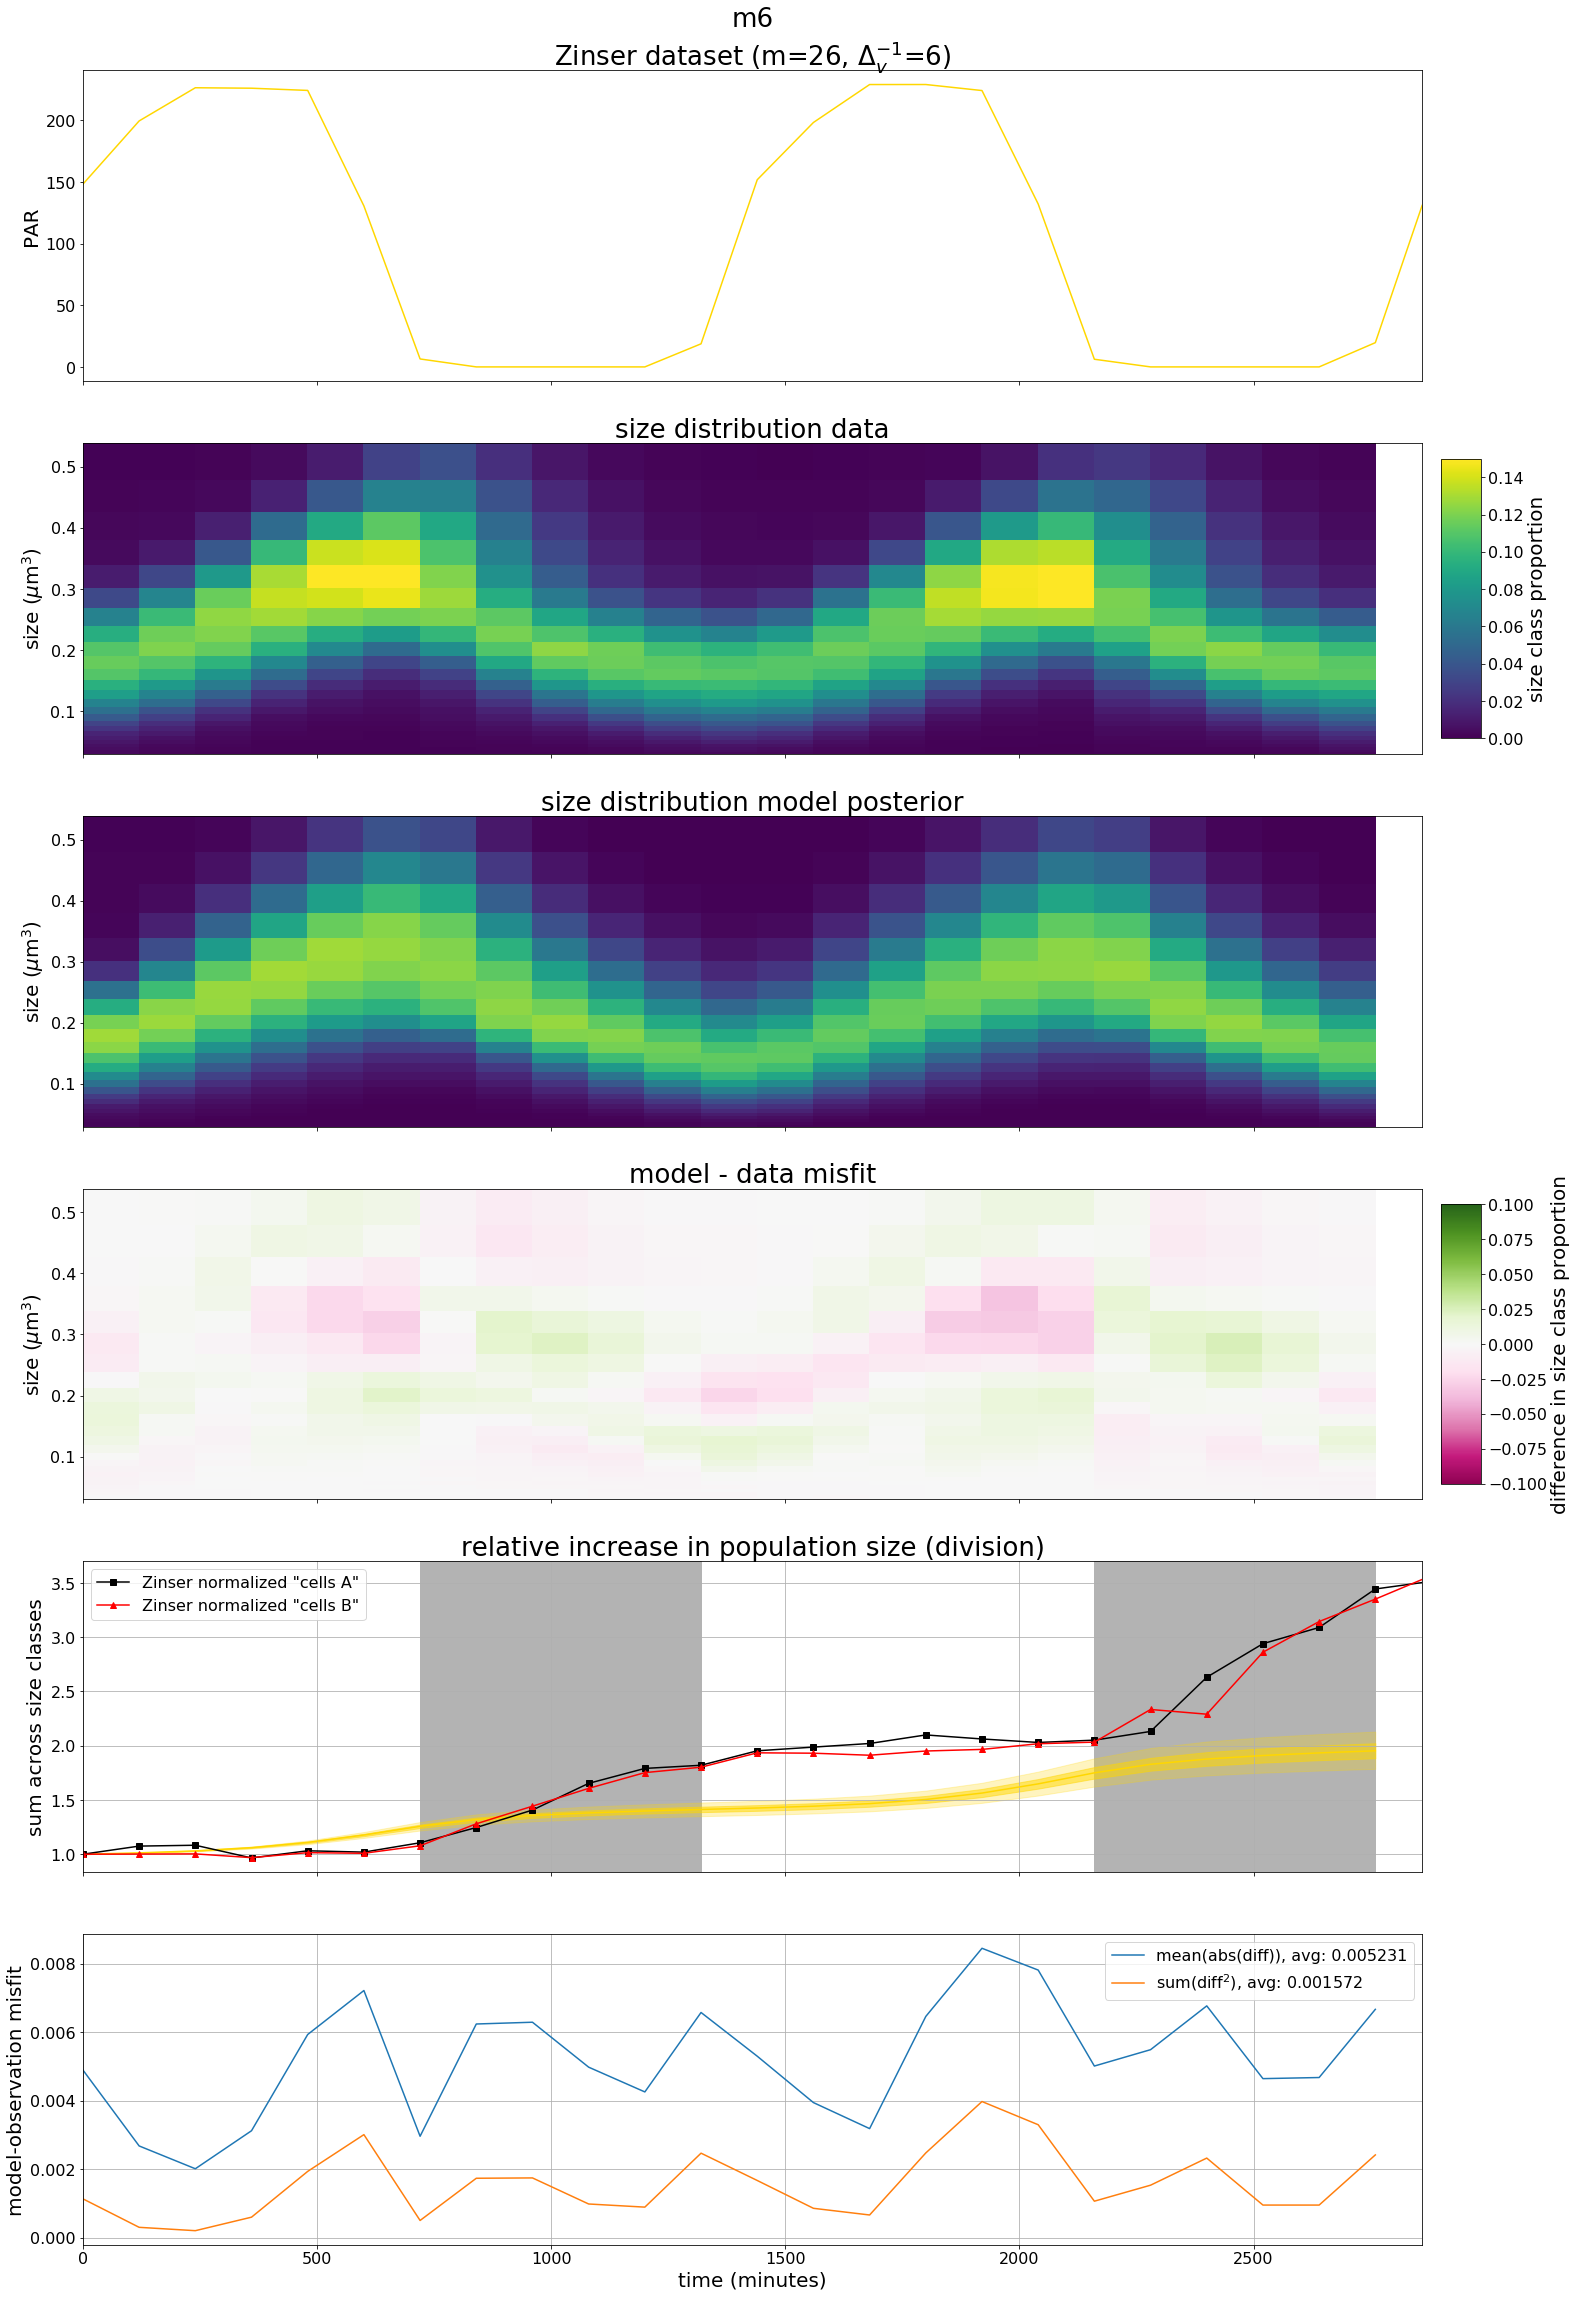

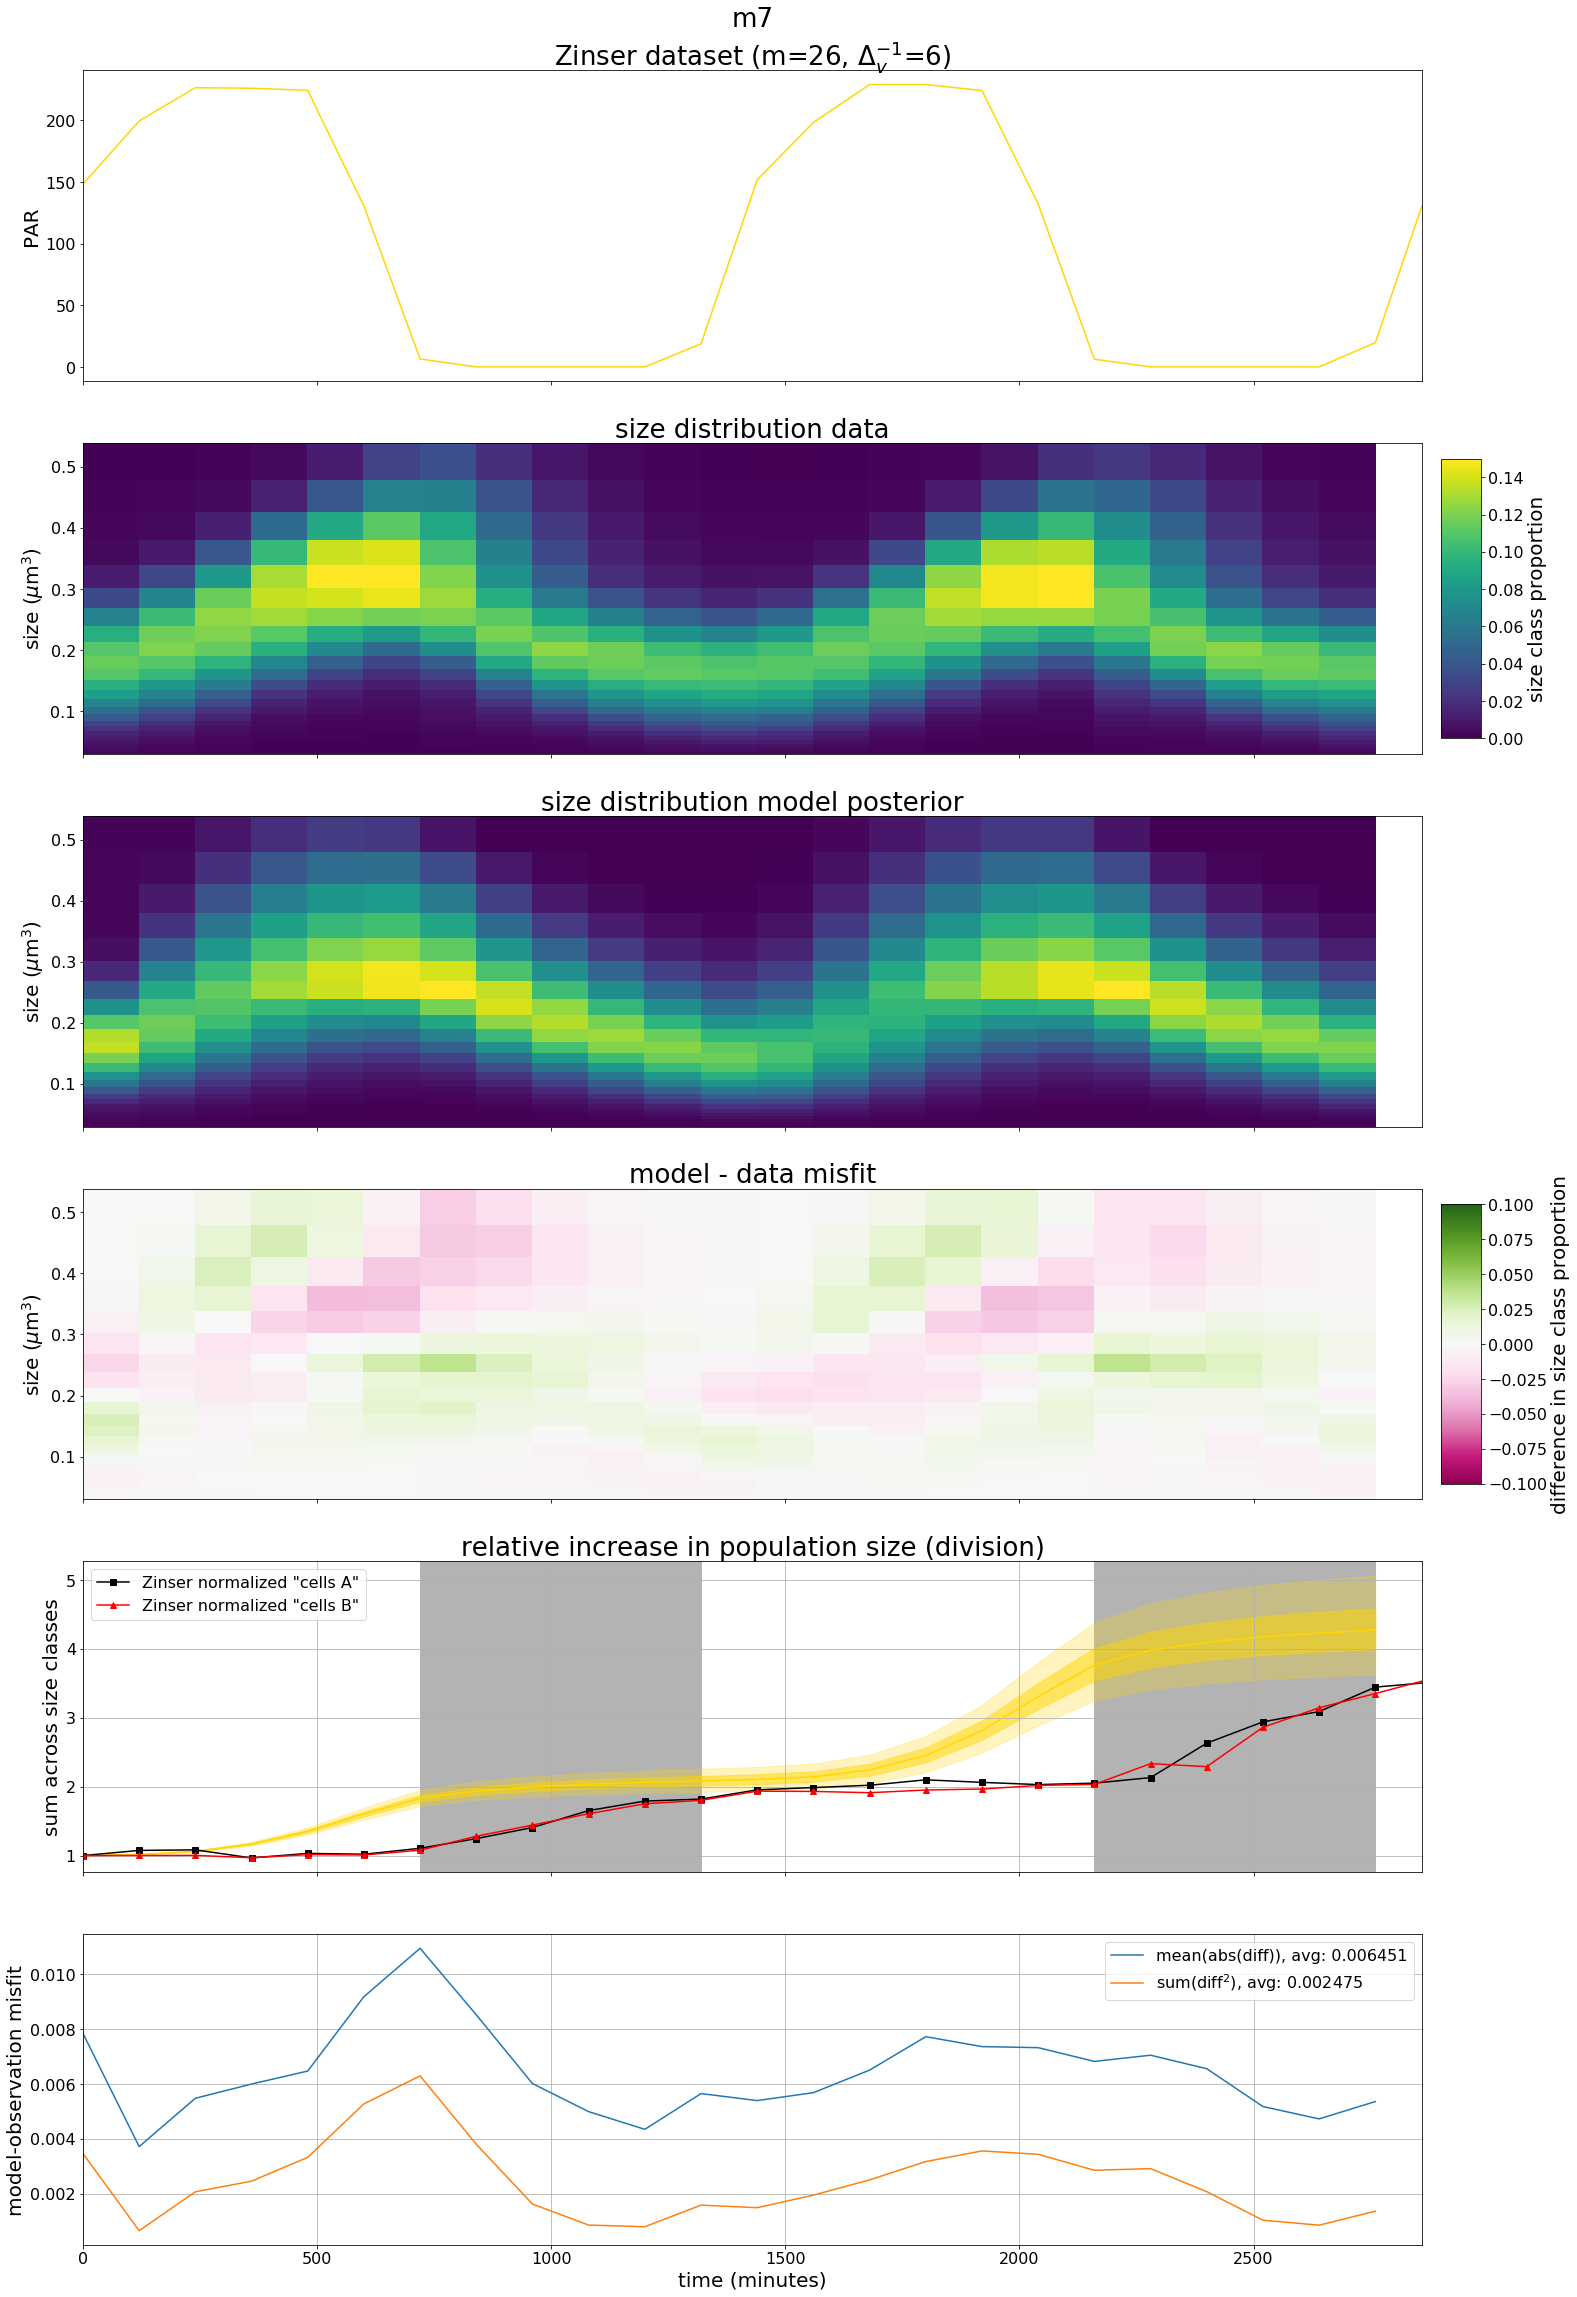

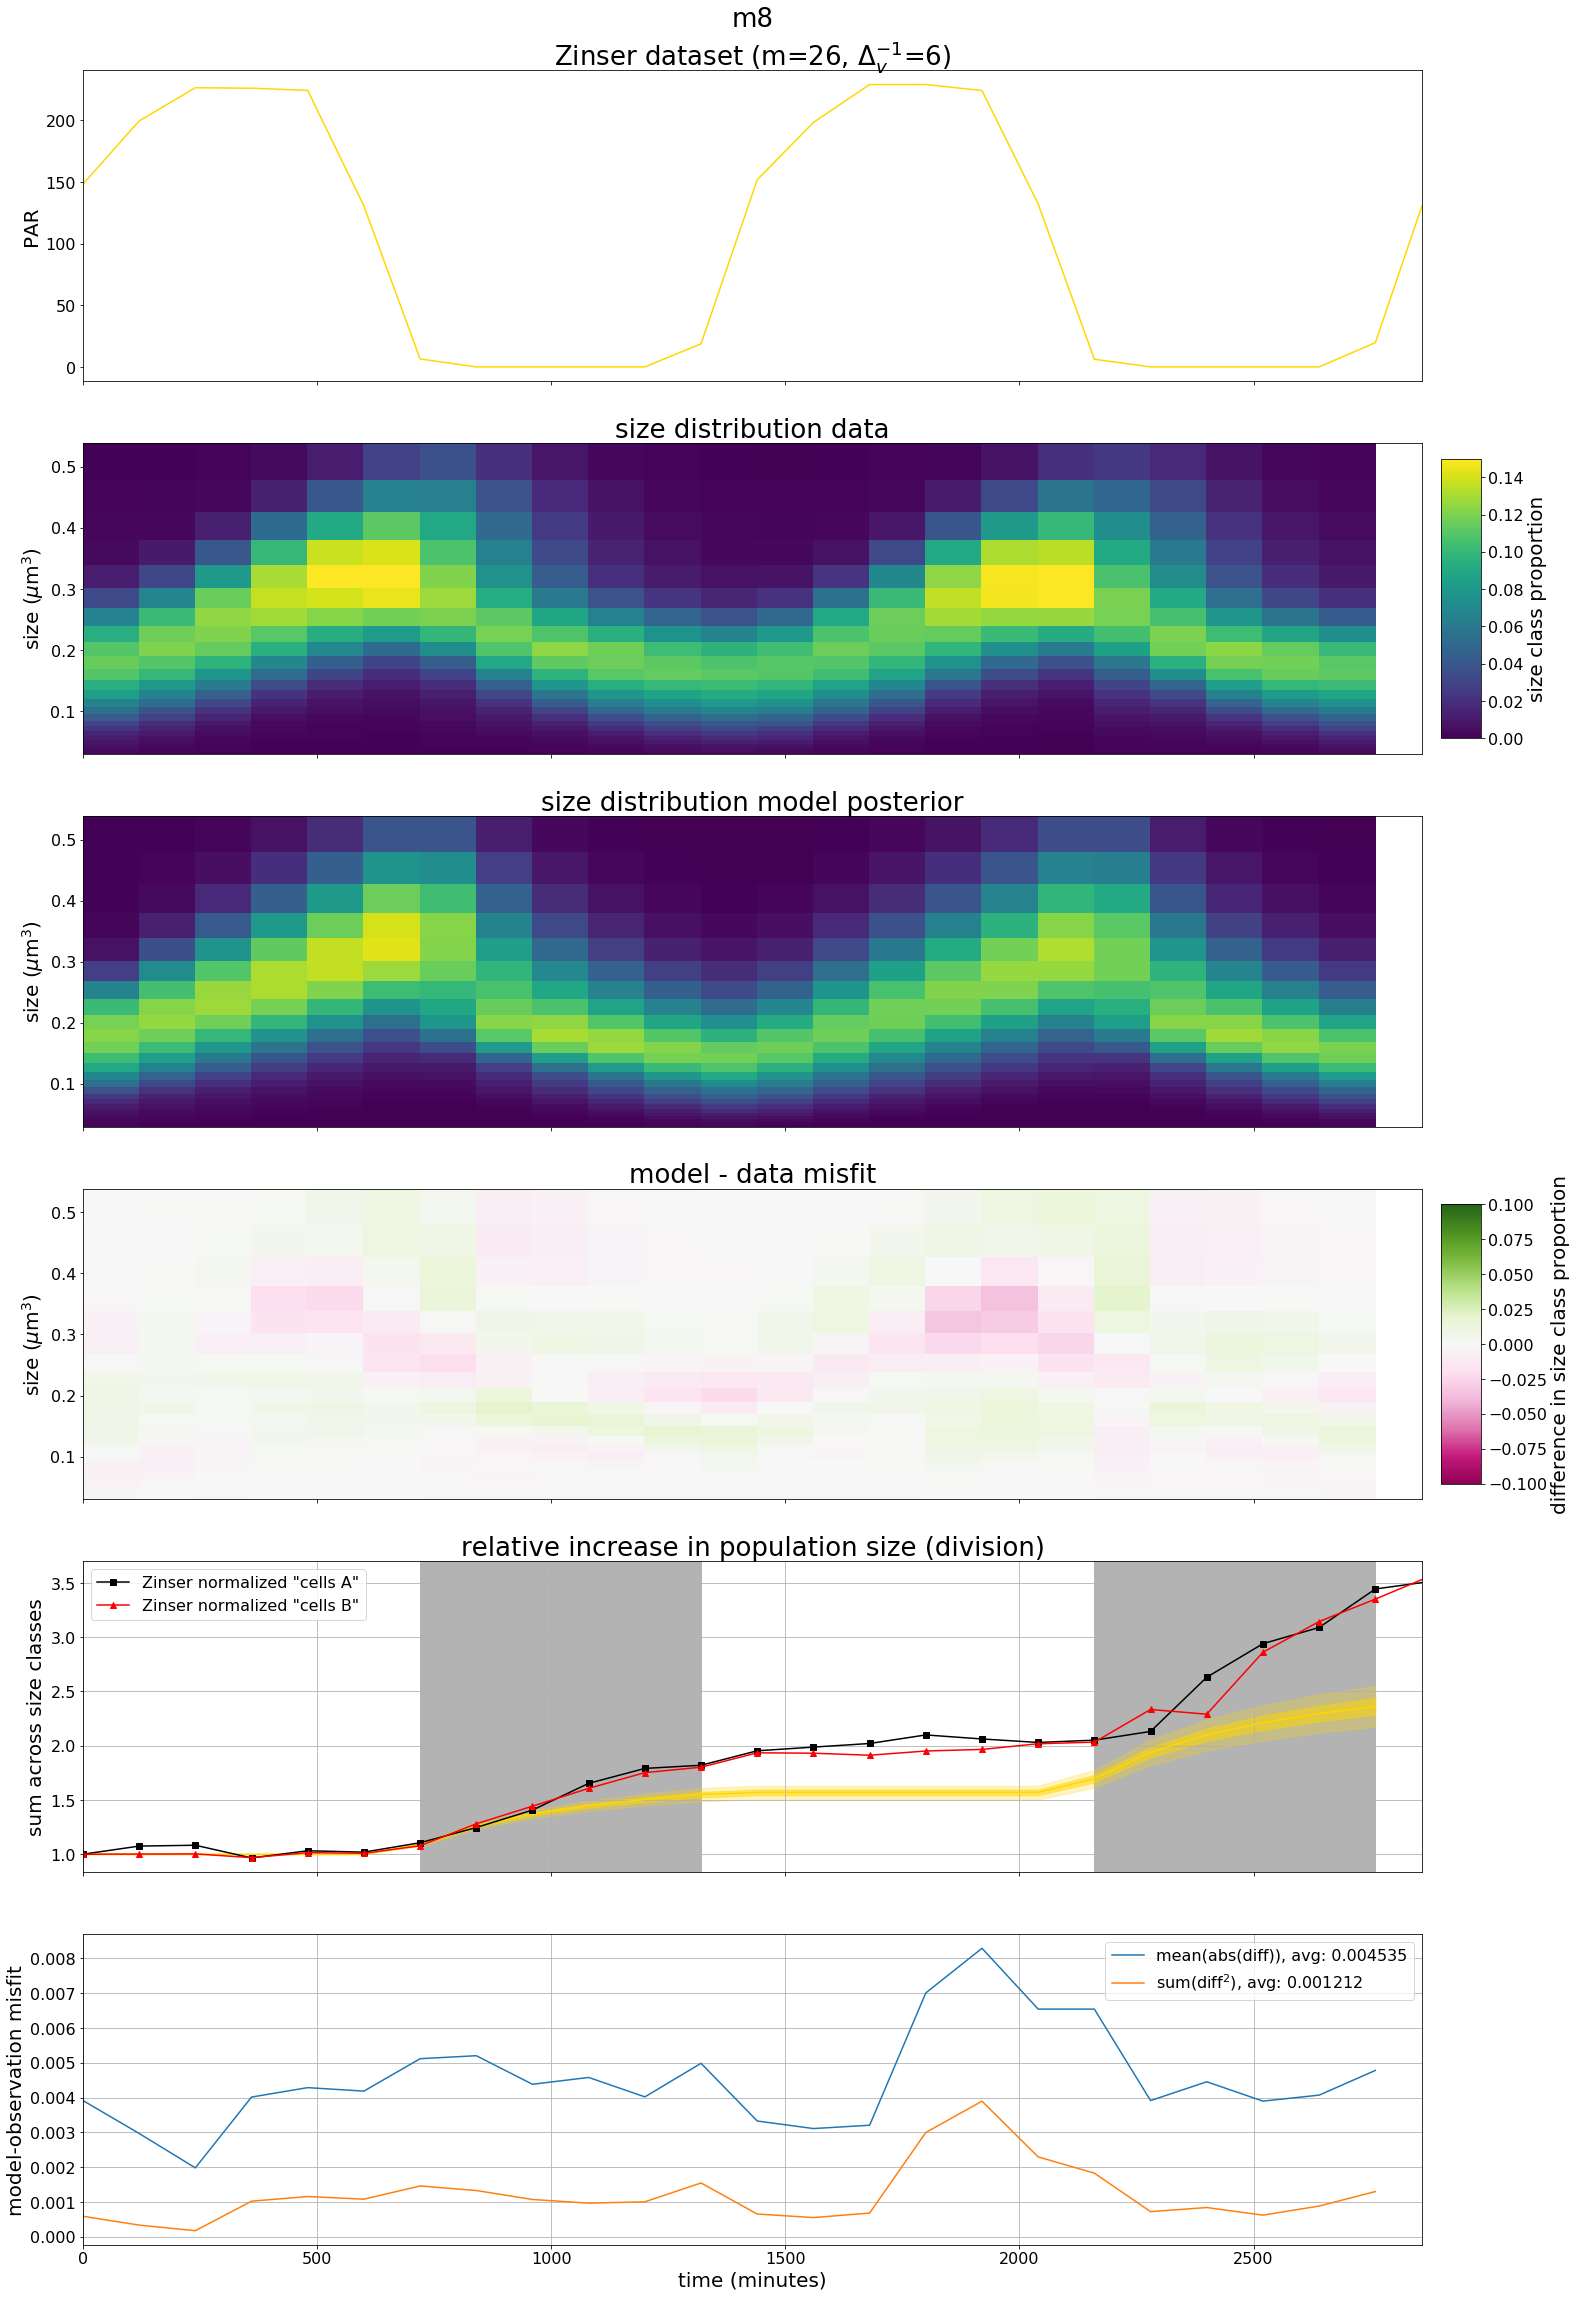

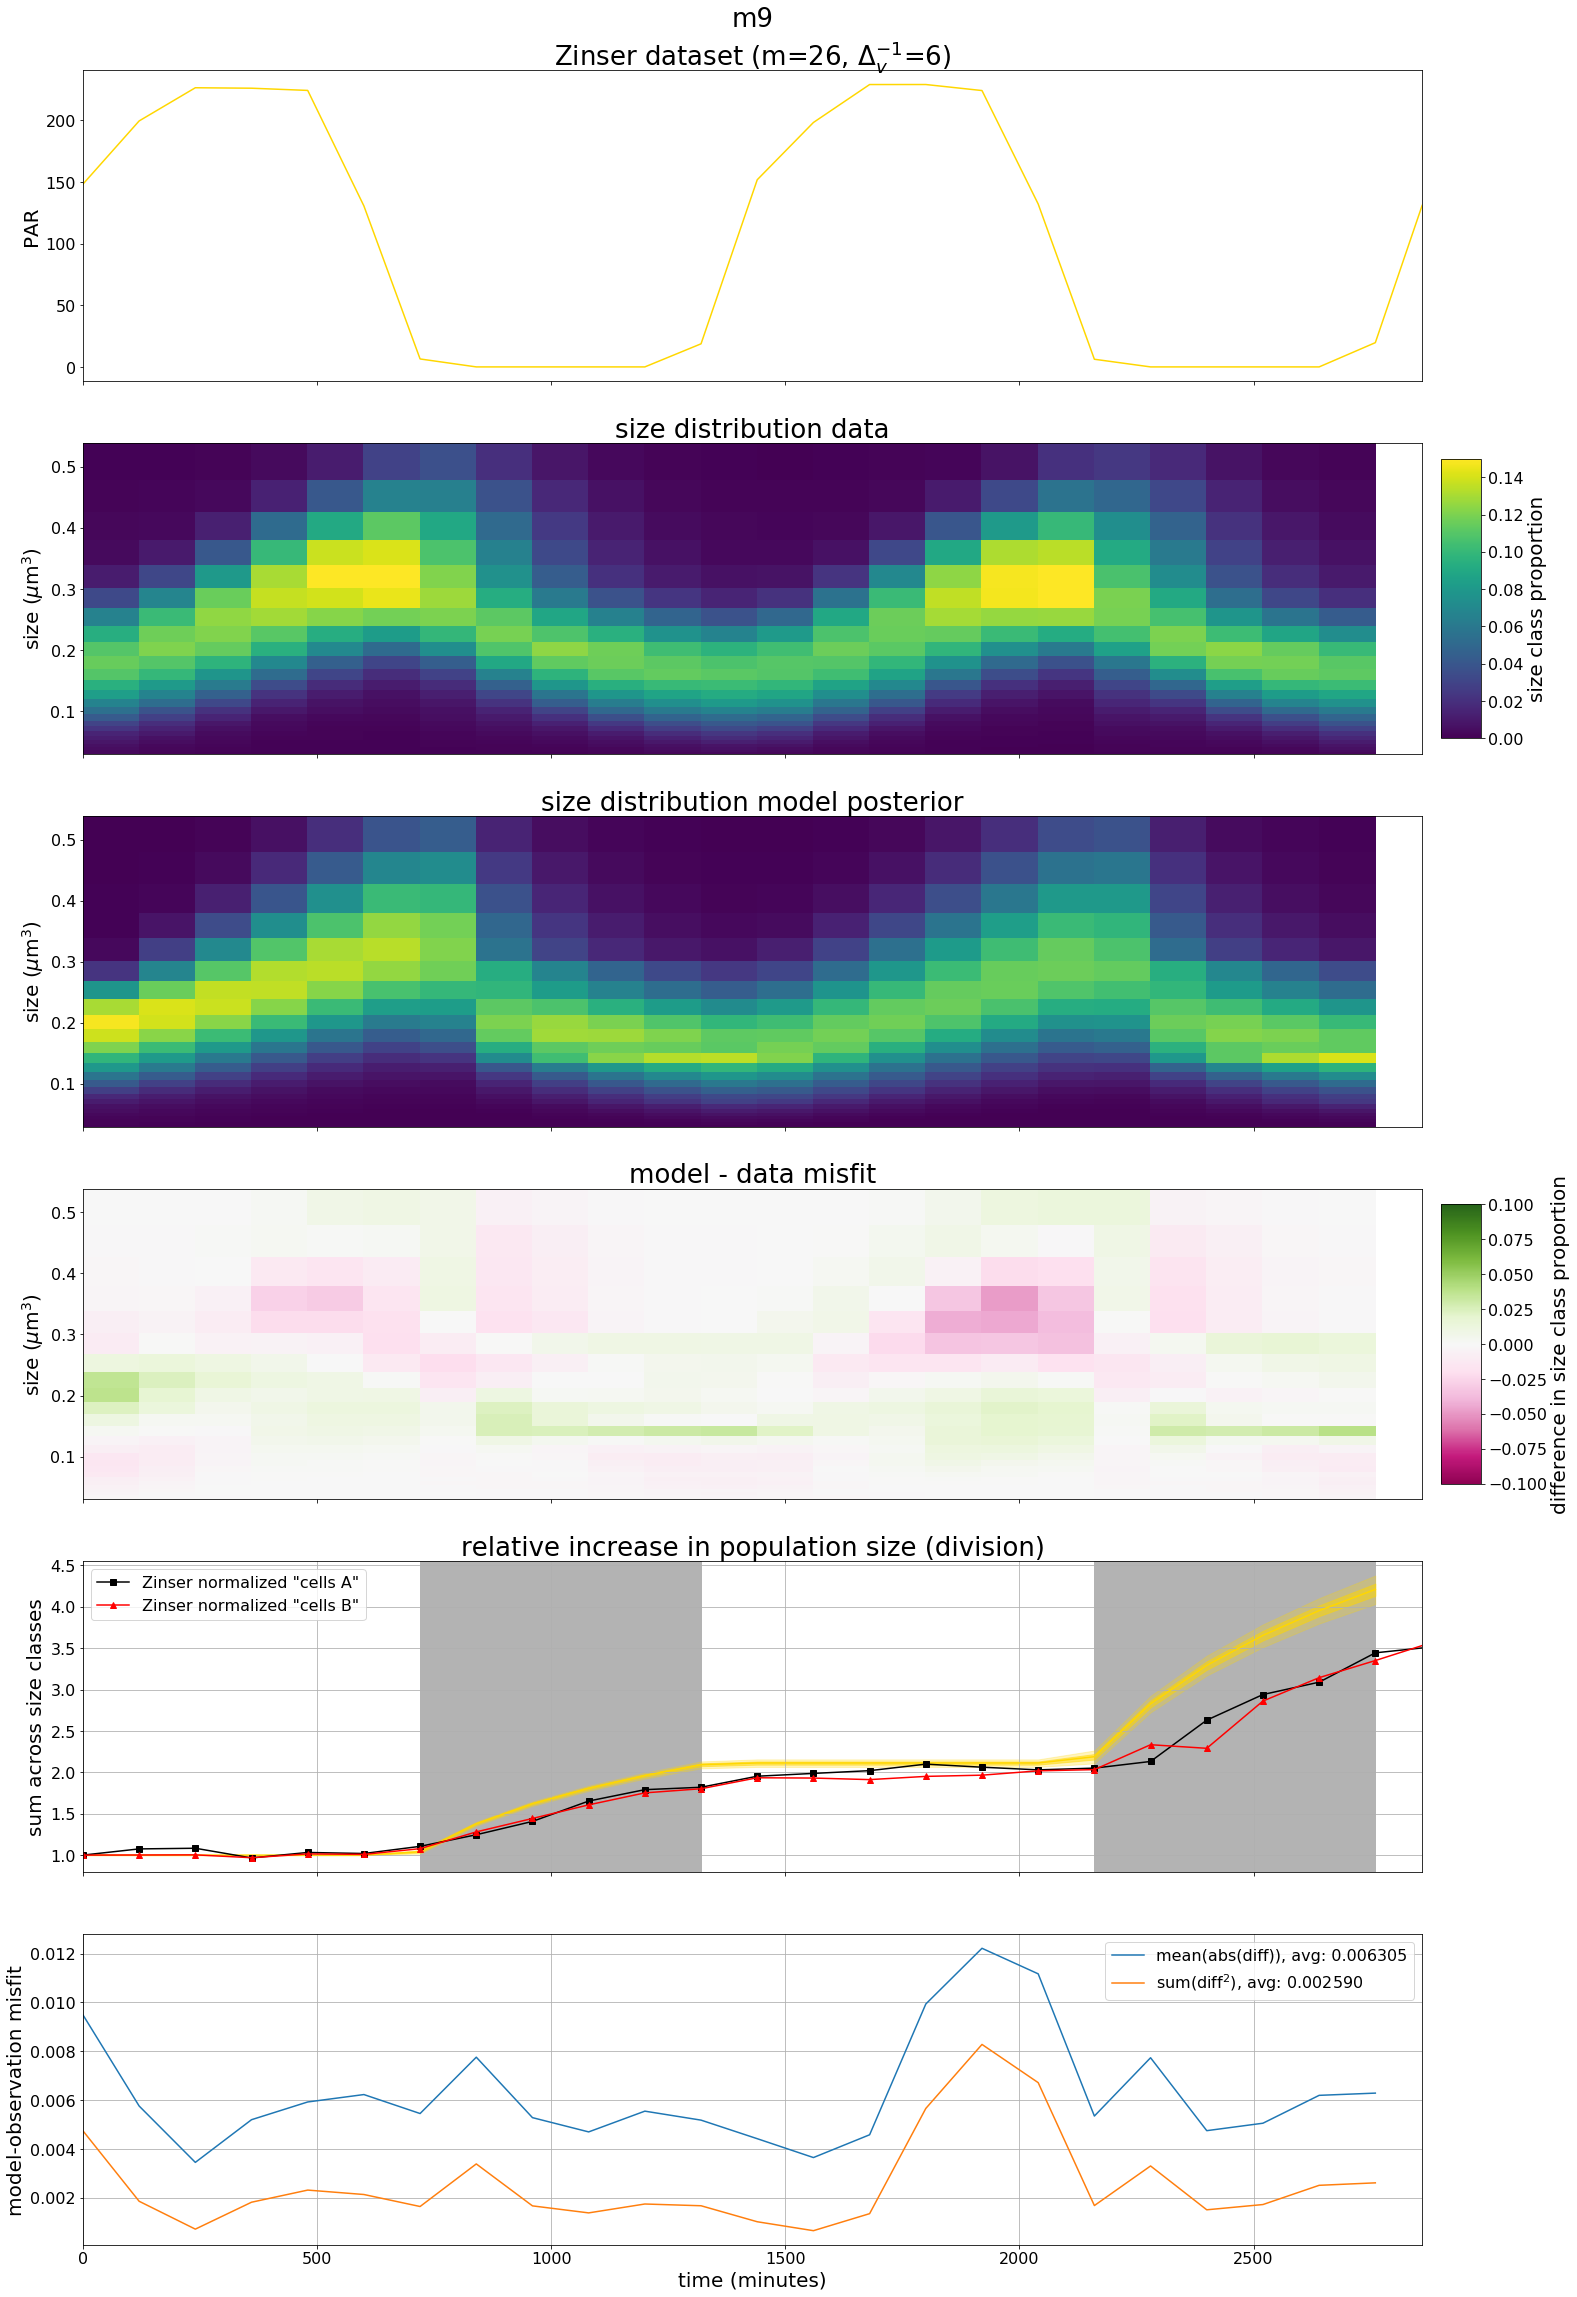

In [33]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for model,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[model][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[model] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[model] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [34]:
'''
import netCDF4 as nc4

for dataname in data:

    ncname = 'data_exp_zs_20200624_gallery2_test_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,model in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[model][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                if i == 0:
                    nc.variables['sumsqdiff'].setncattr('data_used', 'all data')
            else:
                nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                if i == 0:
                    nc.variables['sumsqdiff'].setncattr('data_used', 'testing data')
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[model][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[model][dataname][v]
'''
None